## Followed this notebook: https://github.com/EmuKit/emukit/blob/main/notebooks/Emukit-tutorial-multi-fidelity.ipynb

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import yaml
import importlib.util
import random
random.seed(42)

import GPy
from emukit.multi_fidelity.kernels import LinearMultiFidelityKernel
from emukit.multi_fidelity.models import GPyLinearMultiFidelityModel
from emukit.model_wrappers.gpy_model_wrappers import GPyMultiOutputWrapper
from emukit.multi_fidelity.convert_lists_to_array import convert_x_list_to_array, convert_xy_lists_to_arrays

In [2]:
with open("../coherent/settings_newdata.yaml", "r") as f:
    config_file = yaml.safe_load(f)

version       = config_file["path_settings"]["version"]
path_out_cnp  = config_file["path_settings"]["path_out_cnp"]
path_out_mfgp = config_file["path_settings"]["path_out_mfgp"]
file_in=f'{path_out_cnp}/cnp_{version}_output_20epochs.csv'

In [3]:
# data processing/setup
np.random.seed(42)

if not os.path.exists(path_out_mfgp):
   os.makedirs(path_out_mfgp)

# Set parameter name/x_labels -> needs to be consistent with data input file
x_labels        = config_file["simulation_settings"]["theta_headers"]
y_label_cnp     = 'y_cnp'
y_err_label_cnp = 'y_cnp_err'
y_label_sim     = 'y_raw'

In [4]:
data=pd.read_csv(file_in)

LF_cnp_noise=np.mean(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
HF_cnp_noise=np.mean(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_err_label_cnp].to_numpy())
LF_sim_noise=np.std(data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy())
HF_sim_noise=np.std(data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy())

#x_train_l, x_train_h, y_train_l, y_train_h = ([],[],[],[])
#row_h=data.index[data['fidelity'] == 1].tolist()
#row_l=data.index[data['fidelity'] == 0].tolist()

#x_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_hf_sim = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()

#x_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_hf_cnp = data.loc[(data['fidelity']==1.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()

#x_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
#y_train_lf_sim = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_sim].to_numpy().tolist()


# Get the filtered dataframe first
filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# # Get unique combinations of x_label values to select diverse training points
# unique_x_combinations = filtered_data[x_labels].drop_duplicates()

# # Select up to 3 diverse training points based on different x_label combinations
# if len(unique_x_combinations) >= 3:
#     # Select 3 points with most diverse x values
#     # Get min, max, and a middle point for each x dimension
#     x_data = unique_x_combinations.values
    
#     # Find points with min/max values for first dimension (water_shielding_mm)
#     min_x1_idx = np.argmin(x_data[:, 0])
#     max_x1_idx = np.argmax(x_data[:, 0])
    
#     # Find a point with different x2 value (veto_thickness_mm) that's not min/max x1
#     remaining_indices = [i for i in range(len(x_data)) if i not in [min_x1_idx, max_x1_idx]]
#     if remaining_indices:
#         # Select point with most different x2 value from the min/max x1 points
#         x1_values = x_data[[min_x1_idx, max_x1_idx], 1]
#         mid_x2_idx = remaining_indices[np.argmax([abs(x_data[i, 1] - np.mean(x1_values)) for i in remaining_indices])]
#     else:
#         mid_x2_idx = min_x1_idx if min_x1_idx != max_x1_idx else 0
    
#     selected_combinations = unique_x_combinations.iloc[[min_x1_idx, max_x1_idx, mid_x2_idx]]
# else:
#     # If fewer than 3 unique combinations, use all available
#     selected_combinations = unique_x_combinations

# # Find the indices in filtered_data that match these selected combinations
# train_indices = []
# for _, combo in selected_combinations.iterrows():
#     # Find first occurrence of this combination in filtered_data
#     mask = (filtered_data[x_labels[0]] == combo[x_labels[0]]) & (filtered_data[x_labels[1]] == combo[x_labels[1]])
#     matching_indices = filtered_data[mask].index.tolist()
#     if matching_indices:
#         train_indices.append(matching_indices[0])  # Take first occurrence

# test_indices = filtered_data.index.difference(train_indices)



# filtered_data = data.loc[(data['fidelity']==1.) & (data['iteration']==0)]

# unique_x_combinations = filtered_data[x_labels].drop_duplicates().values

# combination_1 = []
# combination_2 = []
# combination_3 = []

# samples_with_combination_1 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[0]]
# combination_1.extend(list(set(samples_with_combination_1.index.to_list())))
# samples_with_combination_2 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[1]]
# combination_2.extend(list(set(samples_with_combination_2.index.to_list())))
# samples_with_combination_3 = filtered_data.loc[filtered_data[x_labels].values==unique_x_combinations[2]]
# combination_3.extend(list(set(samples_with_combination_3.index.to_list())))

# random.shuffle(combination_1)
# random.shuffle(combination_2)
# random.shuffle(combination_3)

# combination_1_70 = combination_1[:int(len(combination_1) // (10/9))]
# combination_1_30 = combination_1[int(len(combination_1) // (10/9)):]
# combination_2_70 = combination_2[:int(len(combination_2) // (10/9))]
# combination_2_30 = combination_2[int(len(combination_2) // (10/9)):]
# combination_3_70 = combination_3[:int(len(combination_3) // (10/9))]
# combination_3_30 = combination_3[int(len(combination_3) // (10/9)):]


# # Extract training data
# x_train_hf_sim = filtered_data.loc[train_indices][x_labels].to_numpy().tolist()
# y_train_hf_sim = filtered_data.loc[train_indices][y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[test_indices][x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data.loc[test_indices][y_label_sim].to_numpy().tolist()

# Approach 2
# Extract training data
x_train_hf_sim = filtered_data[x_labels].to_numpy().tolist()
y_train_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# # Extract testing data
# x_test_hf_sim = filtered_data[x_labels].to_numpy().tolist()
# y_test_hf_sim = filtered_data[y_label_sim].to_numpy().tolist()

# ## Approach 3
# # Extract training data
# x_train_hf_sim = filtered_data.loc[combination_1_70][x_labels].to_numpy().tolist()
# x_train_hf_sim.extend(filtered_data.loc[combination_2_70][x_labels].to_numpy().tolist())
# x_train_hf_sim.extend(filtered_data.loc[combination_3_70][x_labels].to_numpy().tolist())
# y_train_hf_sim = filtered_data.loc[combination_1_70][y_label_sim].to_numpy().tolist()
# y_train_hf_sim.extend(filtered_data.loc[combination_2_70][y_label_sim].to_numpy().tolist())
# y_train_hf_sim.extend(filtered_data.loc[combination_3_70][y_label_sim].to_numpy().tolist())
# combined_train_hf_sim = list(zip(x_train_hf_sim, y_train_hf_sim))
# random.shuffle(combined_train_hf_sim)
# x_train_hf_sim, y_train_hf_sim = zip(*combined_train_hf_sim)
# x_train_hf_sim = list(x_train_hf_sim)
# y_train_hf_sim = list(y_train_hf_sim)

# # Extract testing data
# x_test_hf_sim = filtered_data.loc[combination_1_30][x_labels].to_numpy().tolist()
# x_test_hf_sim.extend(filtered_data.loc[combination_2_30][x_labels].to_numpy().tolist())
# x_test_hf_sim.extend(filtered_data.loc[combination_3_30][x_labels].to_numpy().tolist())
# y_test_hf_sim = filtered_data.loc[combination_1_30][y_label_sim].to_numpy().tolist()
# y_test_hf_sim.extend(filtered_data.loc[combination_2_30][y_label_sim].to_numpy().tolist())
# y_test_hf_sim.extend(filtered_data.loc[combination_3_30][y_label_sim].to_numpy().tolist())
# combined_test_hf_sim = list(zip(x_test_hf_sim, y_test_hf_sim))
# random.shuffle(combined_test_hf_sim)
# x_test_hf_sim, y_test_hf_sim = zip(*combined_test_hf_sim)
# x_test_hf_sim = list(x_test_hf_sim)
# y_test_hf_sim = list(y_test_hf_sim)

x_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][x_labels].to_numpy().tolist()
y_train_lf_cnp = data.loc[(data['fidelity']==0.) & (data['iteration']==0)][y_label_cnp].to_numpy().tolist()


trainings_data = {"lf": [x_train_lf_cnp,y_train_lf_cnp], "hf": [x_train_hf_sim,y_train_hf_sim]}#, } "mf": [x_train_hf_cnp,y_train_hf_cnp]
noise = {"lf": LF_cnp_noise, "hf": HF_sim_noise*0.001}#, "hf": 0.0}  # why were mf and hf noise originally set to 0?
# noise = {"lf": 1.7e-6, "hf": 1.7e-6}

In [5]:
fidelities = list(trainings_data.keys())
nfidelities = len(fidelities)

In [6]:
x_train = []
y_train = []
for fidelity in fidelities:
    x_tmp=np.atleast_2d(trainings_data[fidelity][0])
    y_tmp=np.atleast_2d(trainings_data[fidelity][1]).T
    x_train.append(x_tmp)
    y_train.append(y_tmp)

X_train, Y_train = convert_xy_lists_to_arrays(x_train, y_train)

In [7]:
num_fidelities = 2  # just lf and hf for now
kernels = [GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1), GPy.kern.Matern32(input_dim=X_train[0].shape[0] - 1)]  # since there are two theta parameters, input_dim is 2

linear_mf_kernel = LinearMultiFidelityKernel(kernels)
gpy_linear_mf_model = GPyLinearMultiFidelityModel(X_train, Y_train, linear_mf_kernel, n_fidelities = num_fidelities)

# set noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise.fix(noise['lf'])  # lf noise
gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.fix(noise['hf'])  # mf/hf noise

array([0])

In [8]:
# SET KERNEL HYPERPARAMETER BOUNDS
# Low-fidelity kernel (Mat32)
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-6, 1e2)
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-2, 1e3)

# High-fidelity kernel (Mat32_1) 
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-6, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-2, 1e3)

# Scale parameter (correlation between fidelities)
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-3, 1e1)

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.99, noise['lf'] * 1.01)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.99, noise['hf'] * 1.01)

reconstraining parameters gp.multifidelity.Mat32.variance
reconstraining parameters gp.multifidelity.Mat32.lengthscale
reconstraining parameters gp.multifidelity.Mat32_1.variance
reconstraining parameters gp.multifidelity.Mat32_1.lengthscale
reconstraining parameters gp.mixed_noise.Gaussian_noise
reconstraining parameters gp.mixed_noise.Gaussian_noise_1


In [9]:
'''# More aggressive bounds that encourage higher uncertainty
gpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)
gpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)
gpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)

# Allow the scale parameter more freedom
gpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)

# If you can unfix noise, increase it slightly
if hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()
    
    # Set to 1.2x your original noise values with some bounds
    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(
        noise['lf'] * 0.85, noise['lf'] * 1.15)
    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.constrain_bounded(
        noise['hf'] * 0.85, noise['hf'] * 1.15)'''

"# More aggressive bounds that encourage higher uncertainty\ngpy_linear_mf_model['multifidelity.Mat32.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32_1.variance'].constrain_bounded(1e-5, 1e3)\ngpy_linear_mf_model['multifidelity.Mat32.lengthscale'].constrain_bounded(1e-4, 1e2)\ngpy_linear_mf_model['multifidelity.Mat32_1.lengthscale'].constrain_bounded(1e-4, 1e2)\n\n# Allow the scale parameter more freedom\ngpy_linear_mf_model['multifidelity.scale'].constrain_bounded(1e-2, 1e2)\n\n# If you can unfix noise, increase it slightly\nif hasattr(gpy_linear_mf_model.mixed_noise.Gaussian_noise, 'unfix'):\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.unfix()\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.unfix()\n\n    # Set to 1.2x your original noise values with some bounds\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise.constrain_bounded(\n        noise['lf'] * 0.85, noise['lf'] * 1.15)\n    gpy_linear_mf_model.mixed_noise.Gaussian_noise_1.cons

In [10]:
## Wrap the model using the given 'GPyMultiOutputWrapper'
lin_mf_model = GPyMultiOutputWrapper(gpy_linear_mf_model, num_fidelities, n_optimization_restarts=10, verbose_optimization=True)

## Fit the model
lin_mf_model.optimize()

Optimization restart 1/10, f = -2564.822326089569
Optimization restart 2/10, f = -2564.990629022796
Optimization restart 3/10, f = -2564.9906375275027
Optimization restart 4/10, f = -2564.990637704729
Optimization restart 5/10, f = -2564.990633407915
Optimization restart 6/10, f = -2564.990632714569
Optimization restart 7/10, f = -2564.99063439079
Optimization restart 8/10, f = -2564.990635830162
Optimization restart 9/10, f = -2564.9906375793676
Optimization restart 10/10, f = -2564.990487710056


In [11]:
x_plot = np.linspace(0, 120, 200)[:, None]
x_plot2 = np.hstack((x_plot, x_plot))

X_plot = convert_x_list_to_array([x_plot2, x_plot2])

X_plot_l = X_plot[:len(x_plot2)]
X_plot_h = X_plot[len(x_plot2):]

## Compute mean predictions and associated variance
lf_mean_lin_mf_model, lf_var_lin_mf_model = lin_mf_model.predict(X_plot_l)
lf_std_lin_mf_model = np.sqrt(lf_var_lin_mf_model)
hf_mean_lin_mf_model, hf_var_lin_mf_model = lin_mf_model.predict(X_plot_h)
hf_std_lin_mf_model = np.sqrt(hf_var_lin_mf_model)

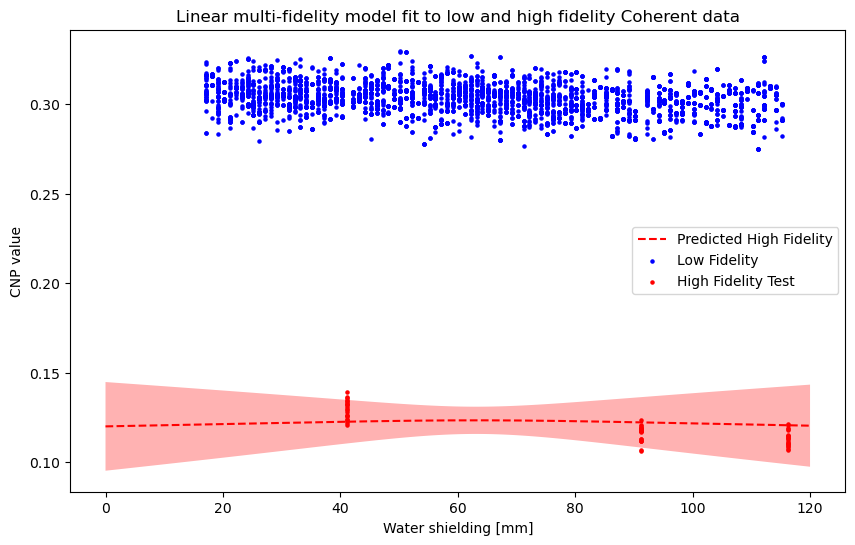

In [13]:
## Plot the posterior mean and variance (water shielding)
plt.figure(figsize=(10, 6))
#plt.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='b', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='r', alpha=0.3)

#plt.plot(x_plot, lf_mean_lin_mf_model, '--', color='b', label='Predicted Low Fidelity')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='r', label='Predicted High Fidelity')
plt.scatter(np.array(x_train_lf_cnp)[:,0], y_train_lf_cnp, color='b', s=5, label='Low Fidelity')
plt.scatter(np.array(x_test_hf_sim)[:,0], y_test_hf_sim, color='r', s=5, label='High Fidelity Test')
plt.xlabel('Water shielding [mm]')
plt.ylabel('CNP value')
plt.legend()
plt.title('Linear multi-fidelity model fit to low and high fidelity Coherent data')
plt.show()

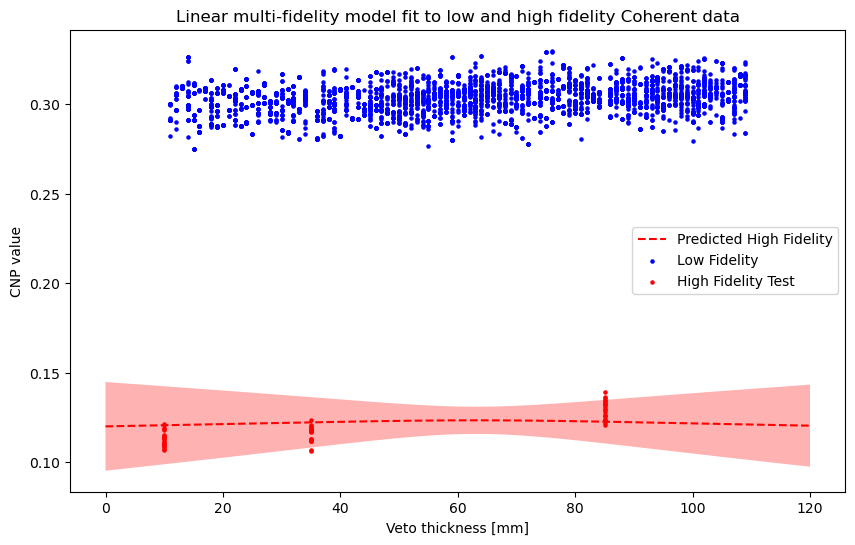

In [14]:
## Plot the posterior mean and variance (veto thickness)
plt.figure(figsize=(10, 6))
#plt.fill_between(x_plot.flatten(), (lf_mean_lin_mf_model - 1.96*lf_std_lin_mf_model).flatten(), (lf_mean_lin_mf_model + 1.96*lf_std_lin_mf_model).flatten(), facecolor='b', alpha=0.3)
plt.fill_between(x_plot.flatten(), (hf_mean_lin_mf_model - 1.96*hf_std_lin_mf_model).flatten(), 
                 (hf_mean_lin_mf_model + 1.96*hf_std_lin_mf_model).flatten(), facecolor='r', alpha=0.3)

#plt.plot(x_plot, lf_mean_lin_mf_model, '--', color='b', label='Predicted Low Fidelity')
plt.plot(x_plot, hf_mean_lin_mf_model, '--', color='r', label='Predicted High Fidelity')
plt.scatter(np.array(x_train_lf_cnp)[:,1], y_train_lf_cnp, color='b', s=5, label='Low Fidelity')
plt.scatter(np.array(x_test_hf_sim)[:,1], y_test_hf_sim, color='r', s=5, label='High Fidelity Test')
plt.xlabel('Veto thickness [mm]')
plt.ylabel('CNP value')
plt.legend()
plt.title('Linear multi-fidelity model fit to low and high fidelity Coherent data')
plt.show()

In [19]:
# Convert to numpy arrays
x_arr = np.array(x_test_hf_sim)  # your x data
y_arr = np.array(y_test_hf_sim)  # your y values

# Create boolean masks for each group
mask1 = (x_arr[:, 0] == 116.2) & (x_arr[:, 1] == 10.0)
mask2 = (x_arr[:, 0] == 91.2) & (x_arr[:, 1] == 35.0)
mask3 = (x_arr[:, 0] == 41.2) & (x_arr[:, 1] == 85.0)

# Split both x and y data using the same masks
x_group1, y_group1 = x_arr[mask1].tolist(), y_arr[mask1].tolist()
x_group2, y_group2 = x_arr[mask2].tolist(), y_arr[mask2].tolist()
x_group3, y_group3 = x_arr[mask3].tolist(), y_arr[mask3].tolist()

In [21]:
theta_test = np.array([[116.2,10.0,1],[91.2,35.0,1],[41.2,85.0,1]])

hf_mean, hf_var = lin_mf_model.predict(theta_test)
hf_std = np.sqrt(hf_var)

print(f'(116.2, 10.0) mean: {hf_mean[0]}, var: {hf_var[0]}, std: {hf_std[0]}')
print(f'(91.2, 35.0) mean: {hf_mean[1]}, var: {hf_var[1]}, std: {hf_std[1]}')
print(f'(41.2, 85.0) mean: {hf_mean[2]}, var: {hf_var[2]}, std: {hf_std[2]}')

(116.2, 10.0) mean: [0.11129361], var: [8.3038068e-06], std: [0.00288163]
(91.2, 35.0) mean: [0.11623812], var: [8.30377292e-06], std: [0.00288163]
(41.2, 85.0) mean: [0.1274339], var: [8.30385395e-06], std: [0.00288164]


### Plot for (76.2, 50.0) group

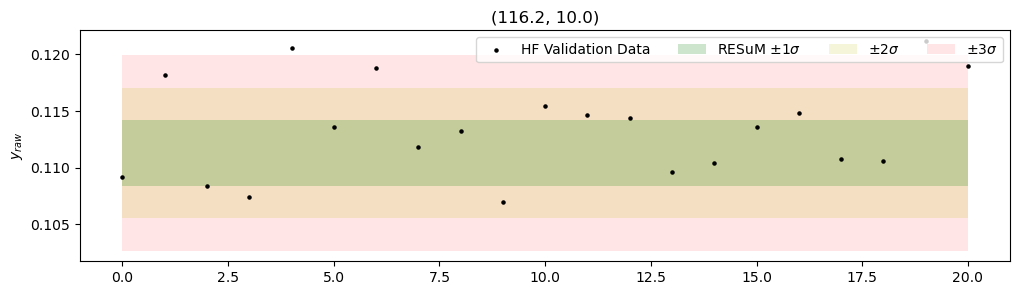

In [22]:
idx_group1 = np.linspace(0, len(x_group1)-1, len(x_group1))
x_plot_g1 = idx_group1[:, None]

vals1 = np.full((len(x_group1), 2), ([116.2,10.0]))
X_plot_g1 = convert_x_list_to_array([vals1, vals1])
X_plot_h_g1 = X_plot_g1[len(vals1):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g1, hf_var_lin_mf_model_g1 = lin_mf_model.predict(X_plot_h_g1)
hf_std_lin_mf_model_g1 = np.sqrt(hf_var_lin_mf_model_g1)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 3*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 3*hf_std_lin_mf_model_g1).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 2*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 2*hf_std_lin_mf_model_g1).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g1.flatten(), (hf_mean_lin_mf_model_g1 - 1*hf_std_lin_mf_model_g1).flatten(), (hf_mean_lin_mf_model_g1 + 1*hf_std_lin_mf_model_g1).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group1, y_group1, color='k', s=5, label='HF Validation Data')
#plt.xlabel('Point index')
plt.ylabel('$y_{raw}$')
plt.title('(116.2, 10.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='upper right')

plt.show()

In [23]:
y_data1 = y_group1  # your HF validation y-values
y_center1 = hf_mean_lin_mf_model_g1[0]  # the central RESuM prediction values
sigma1 = hf_std_lin_mf_model_g1[0]  # the uncertainty values (1σ)

# Calculate how many standard deviations each point is from center
deviations1 = np.abs(y_data1 - y_center1) / sigma1

# Count points within each band
within_1sigma = np.sum(deviations1 <= 1)
within_2sigma = np.sum(deviations1 <= 2) 
within_3sigma = np.sum(deviations1 <= 3)

total_points = len(y_data1)
print('Percentages for (116.2, 10.0)')
print(f"±1σ: {within_1sigma}/{total_points} ({100*within_1sigma/total_points:.1f}%)")
print(f"±2σ: {within_2sigma}/{total_points} ({100*within_2sigma/total_points:.1f}%)")
print(f"±3σ: {within_3sigma}/{total_points} ({100*within_3sigma/total_points:.1f}%)")

Percentages for (116.2, 10.0)
±1σ: 9/21 (42.9%)
±2σ: 16/21 (76.2%)
±3σ: 19/21 (90.5%)


### Plot for (116.2, 10.0) group

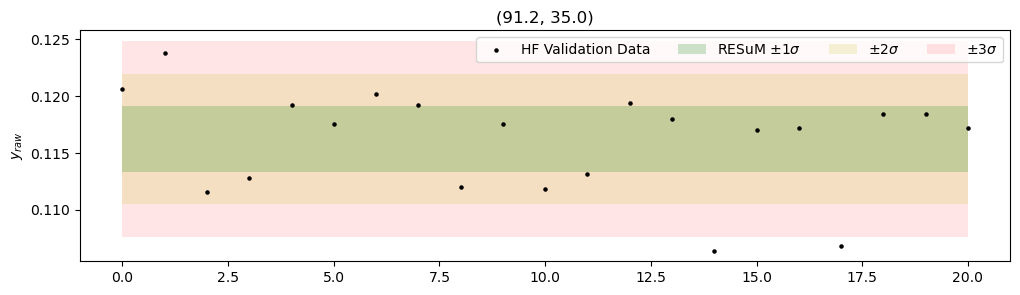

In [24]:
idx_group2 = np.linspace(0, len(x_group2)-1, len(x_group2))
x_plot_g2 = idx_group2[:, None]

vals2 = np.full((len(x_group2), 2), ([91.2,35.0]))
X_plot_g2 = convert_x_list_to_array([vals2, vals2])
X_plot_h_g2 = X_plot_g2[len(vals2):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g2, hf_var_lin_mf_model_g2 = lin_mf_model.predict(X_plot_h_g2)
hf_std_lin_mf_model_g2 = np.sqrt(hf_var_lin_mf_model_g2)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 3*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 3*hf_std_lin_mf_model_g2).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 2*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 2*hf_std_lin_mf_model_g2).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g2.flatten(), (hf_mean_lin_mf_model_g2 - 1*hf_std_lin_mf_model_g2).flatten(), (hf_mean_lin_mf_model_g2 + 1*hf_std_lin_mf_model_g2).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group2, y_group2, color='k', s=5, label='HF Validation Data')
plt.ylabel('$y_{raw}$')
plt.title('(91.2, 35.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='upper right')

plt.show()

In [25]:
y_data2 = y_group2  # your HF validation y-values
y_center2 = hf_mean_lin_mf_model_g2[0]  # the central RESuM prediction values
sigma2 = hf_std_lin_mf_model_g2[0]  # the uncertainty values (1σ)

# Calculate how many standard deviations each point is from center
deviations2 = np.abs(y_data2 - y_center2) / sigma2

# Count points within each band
within_1sigma = np.sum(deviations2 <= 1)
within_2sigma = np.sum(deviations2 <= 2) 
within_3sigma = np.sum(deviations2 <= 3)

total_points = len(y_data2)
print('Percentages for (91.2, 35.0)')
print(f"±1σ: {within_1sigma}/{total_points} ({100*within_1sigma/total_points:.1f}%)")
print(f"±2σ: {within_2sigma}/{total_points} ({100*within_2sigma/total_points:.1f}%)")
print(f"±3σ: {within_3sigma}/{total_points} ({100*within_3sigma/total_points:.1f}%)")

Percentages for (91.2, 35.0)
±1σ: 8/21 (38.1%)
±2σ: 18/21 (85.7%)
±3σ: 19/21 (90.5%)


### Plot for (26.2, 100.0) group

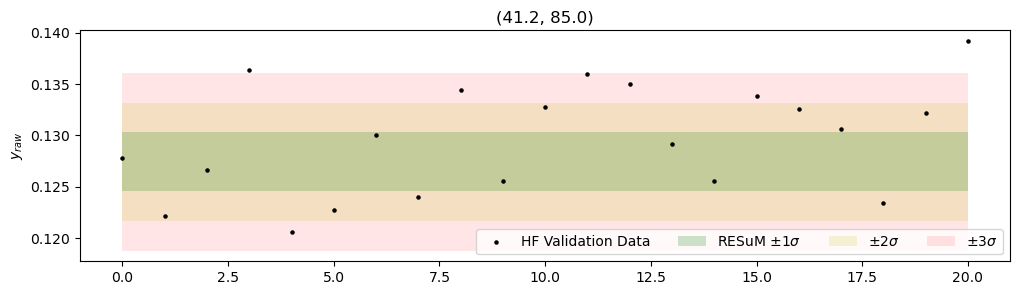

In [26]:
idx_group3 = np.linspace(0, len(x_group3)-1, len(x_group3))
x_plot_g3 = idx_group3[:, None]

vals3 = np.full((len(x_group3), 2), ([41.2,85.0]))
X_plot_g3 = convert_x_list_to_array([vals3, vals3])
X_plot_h_g3 = X_plot_g3[len(vals3):]

## Compute mean predictions and associated variance
hf_mean_lin_mf_model_g3, hf_var_lin_mf_model_g3 = lin_mf_model.predict(X_plot_h_g3)
hf_std_lin_mf_model_g3 = np.sqrt(hf_var_lin_mf_model_g3)

# plotting
plt.figure(figsize=(12, 3))

plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 3*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 3*hf_std_lin_mf_model_g3).flatten(), facecolor='r', alpha=0.1, label='$\\pm 3 \\sigma $')
plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 2*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 2*hf_std_lin_mf_model_g3).flatten(), facecolor='y', alpha=0.15, label='$\\pm 2 \\sigma $')
plt.fill_between(x_plot_g3.flatten(), (hf_mean_lin_mf_model_g3 - 1*hf_std_lin_mf_model_g3).flatten(), (hf_mean_lin_mf_model_g3 + 1*hf_std_lin_mf_model_g3).flatten(), facecolor='g', alpha=0.2, label='RESuM $\\pm 1 \\sigma $')

plt.scatter(idx_group3, y_group3, color='k', s=5, label='HF Validation Data')
plt.ylabel('$y_{raw}$')
plt.title('(41.2, 85.0)')

handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], ncol=4, loc='lower right')

plt.show()

In [27]:
y_data3 = y_group3  # your HF validation y-values
y_center3 = hf_mean_lin_mf_model_g3[0]  # the central RESuM prediction values
sigma3 = hf_std_lin_mf_model_g3[0]  # the uncertainty values (1σ)

# Calculate how many standard deviations each point is from center
deviations3 = np.abs(y_data3 - y_center3) / sigma3

# Count points within each band
within_1sigma = np.sum(deviations3 <= 1)
within_2sigma = np.sum(deviations3 <= 2) 
within_3sigma = np.sum(deviations3 <= 3)

total_points = len(y_data3)
print('Percentages for (41.2, 85.0)')
print(f"±1σ: {within_1sigma}/{total_points} ({100*within_1sigma/total_points:.1f}%)")
print(f"±2σ: {within_2sigma}/{total_points} ({100*within_2sigma/total_points:.1f}%)")
print(f"±3σ: {within_3sigma}/{total_points} ({100*within_3sigma/total_points:.1f}%)")

Percentages for (41.2, 85.0)
±1σ: 6/21 (28.6%)
±2σ: 14/21 (66.7%)
±3σ: 19/21 (90.5%)


### Contour Heat Map Visualization

Create a contour heat map showing the predicted y_raw values across the parameter space.

In [28]:
def draw_yraw_contour(mf_model, x_labels, param_x_idx, param_y_idx, x_fixed, grid_steps=40, levels=20, cmap="viridis"):
    """Draw a filled contour plot of the high-fidelity (y_raw) prediction as function of two parameters.

    Parameters
    ----------
    mf_model : GPyMultiOutputWrapper
        The multi-fidelity model.
    x_labels : list
        List of parameter names.
    param_x_idx, param_y_idx : int
        Indices of the parameters to be shown on the horizontal and vertical axes, respectively.
    x_fixed : array-like
        Fixed values for all parameters (will be modified for the two varying parameters).
    grid_steps : int, optional
        Number of grid points along each axis.
    levels : int, optional
        Number of contour levels.
    cmap : str, optional
        Colormap for the filled contours.
    """
    
    # Get parameter ranges from the data
    param_x_min, param_x_max = data[x_labels[param_x_idx]].min(), data[x_labels[param_x_idx]].max()
    param_y_min, param_y_max = data[x_labels[param_y_idx]].min(), data[x_labels[param_y_idx]].max()
    
    # Build grid for the two selected parameters
    x_vals = np.linspace(param_x_min, param_x_max, grid_steps)
    y_vals = np.linspace(param_y_min, param_y_max, grid_steps)
    Xg, Yg = np.meshgrid(x_vals, y_vals)

    # Prepare points to evaluate
    points = []
    for y in y_vals:
        for x in x_vals:
            x_vec = np.array(x_fixed).copy()
            x_vec[param_x_idx] = x
            x_vec[param_y_idx] = y
            points.append(x_vec)

    points = np.array(points)
    
    # For high-fidelity prediction, we need to add fidelity indicator
    # Add fidelity column (1 for high fidelity)
    fidelity_col = np.ones((len(points), 1))
    points_with_fidelity = np.hstack([points, fidelity_col])
    
    # Evaluate model at high fidelity
    mean_pred, _ = mf_model.predict(points_with_fidelity)
    Z = mean_pred.reshape(grid_steps, grid_steps)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 8), constrained_layout=True)
    contour = ax.contourf(Xg, Yg, Z, levels=levels, cmap=cmap)
    cbar = fig.colorbar(contour, ax=ax)
    cbar.set_label(r"Predicted $y_{raw}$", fontsize=12)

    ax.set_xlabel(x_labels[param_x_idx], fontsize=12)
    ax.set_ylabel(x_labels[param_y_idx], fontsize=12)
    ax.set_title(r"Predicted $y_{raw}$ Contour Map", fontsize=14)

    # Add contour lines for better readability
    contour_lines = ax.contour(Xg, Yg, Z, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    
    # Overlay training data points
    ax.scatter(np.array(x_train_hf_sim)[:, param_x_idx], 
               np.array(x_train_hf_sim)[:, param_y_idx], 
               c='red', s=100, marker='o', edgecolors='black', linewidth=2, 
               label='HF Training Data', zorder=5)
    
    # Overlay low-fidelity training data points
    ax.scatter(np.array(x_train_lf_cnp)[:, param_x_idx], 
               np.array(x_train_lf_cnp)[:, param_y_idx], 
               c='blue', s=30, marker='s', alpha=0.6, 
               label='LF Training Data', zorder=4)

    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)

    return fig

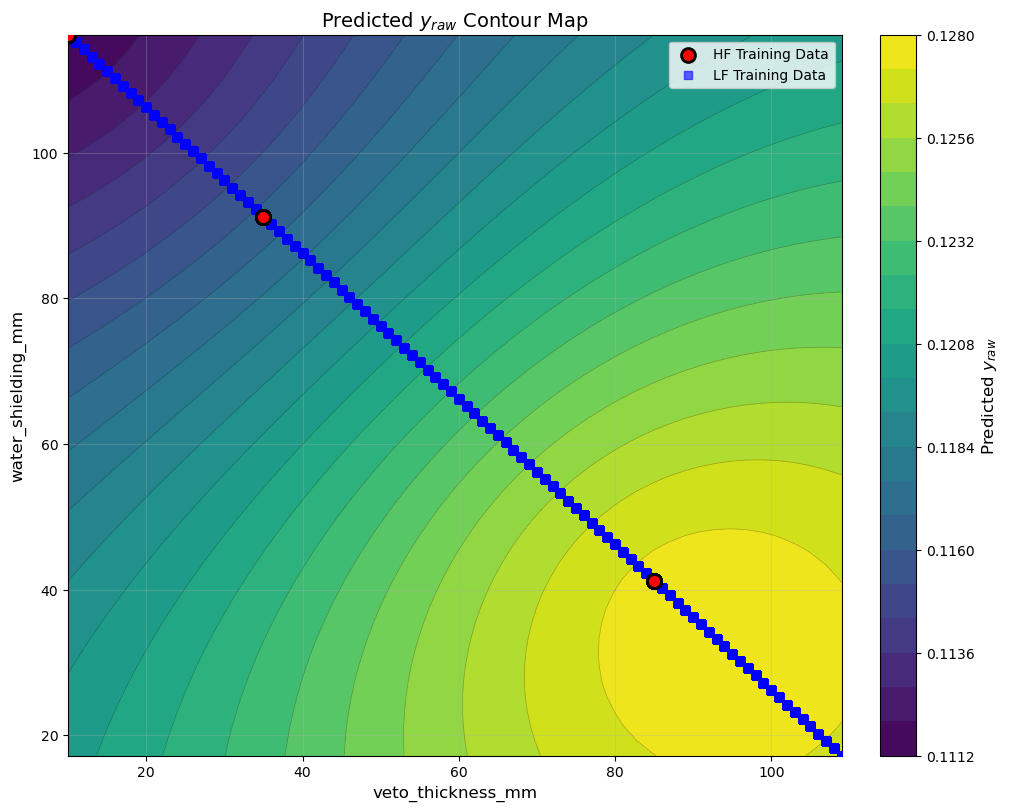

In [29]:
# Create contour heat map for water_shielding_mm (x-axis) vs veto_thickness_mm (y-axis)
# Define fixed parameter values (using mean values from the training data)
x_fixed = [np.mean(np.array(x_train_lf_cnp)[:, i]) for i in range(len(x_labels))]

# Create the contour plot
# x_labels[0] should be water_shielding_mm, x_labels[1] should be veto_thickness_mm
param_x_idx = 1  # water_shielding_mm
param_y_idx = 0  # veto_thickness_mm

fig_contour = draw_yraw_contour(lin_mf_model, x_labels, param_x_idx, param_y_idx, x_fixed, 
                               grid_steps=50, levels=25, cmap="viridis")
plt.show()

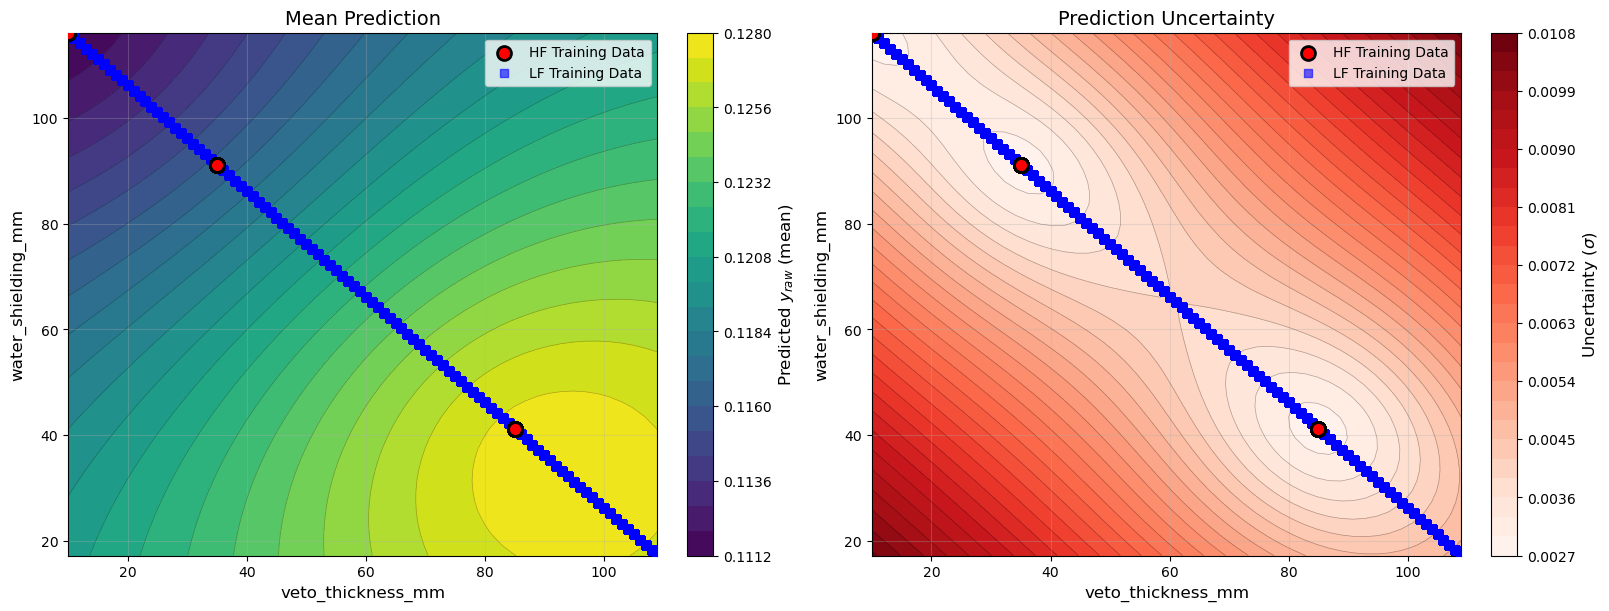

In [30]:
# Create a more detailed contour plot with uncertainty visualization
def draw_yraw_contour_with_uncertainty(mf_model, x_labels, param_x_idx, param_y_idx, x_fixed, grid_steps=40, levels=20, cmap="viridis"):
    """Draw contour plots showing both mean prediction and uncertainty."""
    
    # Get parameter ranges from the data
    param_x_min, param_x_max = data[x_labels[param_x_idx]].min(), data[x_labels[param_x_idx]].max()
    param_y_min, param_y_max = data[x_labels[param_y_idx]].min(), data[x_labels[param_y_idx]].max()
    
    # Build grid for the two selected parameters
    x_vals = np.linspace(param_x_min, param_x_max, grid_steps)
    y_vals = np.linspace(param_y_min, param_y_max, grid_steps)
    Xg, Yg = np.meshgrid(x_vals, y_vals)

    # Prepare points to evaluate
    points = []
    for y in y_vals:
        for x in x_vals:
            x_vec = np.array(x_fixed).copy()
            x_vec[param_x_idx] = x
            x_vec[param_y_idx] = y
            points.append(x_vec)

    points = np.array(points)
    
    # For high-fidelity prediction, we need to add fidelity indicator
    fidelity_col = np.ones((len(points), 1))
    points_with_fidelity = np.hstack([points, fidelity_col])
    
    # Evaluate model at high fidelity
    mean_pred, var_pred = mf_model.predict(points_with_fidelity)
    std_pred = np.sqrt(var_pred)
    
    Z_mean = mean_pred.reshape(grid_steps, grid_steps)
    Z_std = std_pred.reshape(grid_steps, grid_steps)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), constrained_layout=True)
    
    # Plot 1: Mean prediction
    contour1 = ax1.contourf(Xg, Yg, Z_mean, levels=levels, cmap=cmap)
    cbar1 = fig.colorbar(contour1, ax=ax1)
    cbar1.set_label(r"Predicted $y_{raw}$ (mean)", fontsize=12)
    
    ax1.set_xlabel(x_labels[param_x_idx], fontsize=12)
    ax1.set_ylabel(x_labels[param_y_idx], fontsize=12)
    ax1.set_title(r"Mean Prediction", fontsize=14)
    
    # Add contour lines and training data
    ax1.contour(Xg, Yg, Z_mean, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    ax1.scatter(np.array(x_train_hf_sim)[:, param_x_idx], 
               np.array(x_train_hf_sim)[:, param_y_idx], 
               c='red', s=100, marker='o', edgecolors='black', linewidth=2, 
               label='HF Training Data', zorder=5)
    ax1.scatter(np.array(x_train_lf_cnp)[:, param_x_idx], 
               np.array(x_train_lf_cnp)[:, param_y_idx], 
               c='blue', s=30, marker='s', alpha=0.6, 
               label='LF Training Data', zorder=4)
    ax1.legend(loc='upper right')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Uncertainty (standard deviation)
    contour2 = ax2.contourf(Xg, Yg, Z_std, levels=levels, cmap='Reds')
    cbar2 = fig.colorbar(contour2, ax=ax2)
    cbar2.set_label(r"Uncertainty ($\sigma$)", fontsize=12)
    
    ax2.set_xlabel(x_labels[param_x_idx], fontsize=12)
    ax2.set_ylabel(x_labels[param_y_idx], fontsize=12)
    ax2.set_title(r"Prediction Uncertainty", fontsize=14)
    
    # Add contour lines and training data
    ax2.contour(Xg, Yg, Z_std, levels=levels, colors='black', alpha=0.3, linewidths=0.5)
    ax2.scatter(np.array(x_train_hf_sim)[:, param_x_idx], 
               np.array(x_train_hf_sim)[:, param_y_idx], 
               c='red', s=100, marker='o', edgecolors='black', linewidth=2, 
               label='HF Training Data', zorder=5)
    ax2.scatter(np.array(x_train_lf_cnp)[:, param_x_idx], 
               np.array(x_train_lf_cnp)[:, param_y_idx], 
               c='blue', s=30, marker='s', alpha=0.6, 
               label='LF Training Data', zorder=4)
    ax2.legend(loc='upper right')
    ax2.grid(True, alpha=0.3)

    return fig

# Create the enhanced contour plot with uncertainty
fig_contour_detailed = draw_yraw_contour_with_uncertainty(lin_mf_model, x_labels, param_x_idx, param_y_idx, x_fixed, 
                                                         grid_steps=50, levels=25, cmap="viridis")
plt.show()

In [26]:
x_train_hf_sim

[[26.2, 100.0], [116.2, 10.0], [76.2, 50.0]]

In [ ]:
# Save the contour plots
fig_contour.savefig(f'{path_out_mfgp}/yraw_contour_map.png', dpi=300, bbox_inches='tight')
fig_contour_detailed.savefig(f'{path_out_mfgp}/yraw_contour_with_uncertainty.png', dpi=300, bbox_inches='tight') 

print(f"Contour plots saved to {path_out_mfgp}/")
print(f"- yraw_contour_map.png")
print(f"- yraw_contour_with_uncertainty.png")

Contour plots saved to ../coherent/out/mfgp/
- yraw_contour_map.png
- yraw_contour_with_uncertainty.png


## Automated Analysis Pipeline for Multiple CSV Files

This section imports and uses a comprehensive automated analysis pipeline that can:
- ✅ Process any number of CSV files with glob patterns
- ✅ Gather samples with unique theta values for model prediction
- ✅ Generate prediction plots with uncertainty bands (±1σ, ±2σ, ±3σ)
- ✅ Calculate and plot coverage statistics
- ✅ Create contour maps with input data overlaid
- ✅ Generate uncertainty visualizations
- ✅ **Save all results to output folder automatically**

The `MFGPAnalyzer` class is imported from `mfgp_analyzer.py` to keep the notebook clean.

In [12]:
import importlib
import sys

if 'mfgp_analyzer' in sys.modules:
    del sys.modules['mfgp_analyzer']

# Import the automated analysis pipeline
from mfgp_analyzer import MFGPAnalyzer, explore_predictions

print("✅ MFGPAnalyzer imported successfully!")
print("✅ All analysis results will be saved to the output folder")

✅ MFGPAnalyzer imported successfully!
✅ All analysis results will be saved to the output folder


### Usage Example

Now let's use the automated analysis pipeline to process CSV files and generate comprehensive analysis.

In [13]:
# Initialize the automated analyzer
# All plots and results will be saved to path_out_mfgp
analyzer = MFGPAnalyzer(
    mf_model=lin_mf_model,
    x_labels=x_labels,
    y_label_sim=y_label_sim,
    output_dir=path_out_mfgp  # This ensures all results are saved to the configured output folder
)

print("🎯 MFGPAnalyzer initialized successfully!")
print(f"📁 Output directory: {analyzer.output_dir}")
print(f"📊 Parameter labels: {analyzer.x_labels}")
print(f"🎯 Target variable: {analyzer.y_label_sim}")
print("💾 All plots and analysis results will be automatically saved!")

MFGPAnalyzer initialized:
  Output directory: ../coherent/out/mfgp/newdata
  Parameter labels: ['water_shielding_mm', 'veto_thickness_mm']
  Target variable: y_raw
🎯 MFGPAnalyzer initialized successfully!
📁 Output directory: ../coherent/out/mfgp/newdata
📊 Parameter labels: ['water_shielding_mm', 'veto_thickness_mm']
🎯 Target variable: y_raw
💾 All plots and analysis results will be automatically saved!


EXAMPLE 1: Analyzing the current training file
AUTOMATED MFGP ANALYSIS PIPELINE
Output directory: ../coherent/out/mfgp/newdata

1. Loading and processing CSV files...
Processing: /home/bliu4/resum-coherent2/examples/coherent/out/cnp/newdata/cnp_v104.0_coherent_output_valid_20epochs.csv
  Found 88 unique theta combinations

2. Generating predictions for all theta combinations...

Generating predictions for cnp_v104.0_coherent_output_valid_20epochs.csv
  Theta (47.2, 79.0): mean=0.126312, std=0.002909
  Theta (42.2, 84.0): mean=0.127440, std=0.002882
  Theta (72.2, 54.0): mean=0.120447, std=0.002989
  Theta (75.2, 51.0): mean=0.119752, std=0.002969
  Theta (87.2, 39.0): mean=0.117076, std=0.002889
  Theta (79.2, 47.0): mean=0.118838, std=0.002939
  Theta (59.2, 67.0): mean=0.123511, std=0.003003
  Theta (37.2, 89.0): mean=0.128532, std=0.002902
  Theta (90.2, 36.0): mean=0.116442, std=0.002881
  Theta (38.2, 88.0): mean=0.128317, std=0.002893
  Theta (63.2, 63.0): mean=0.122564, std=0.00

    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_47.2_79.0.png


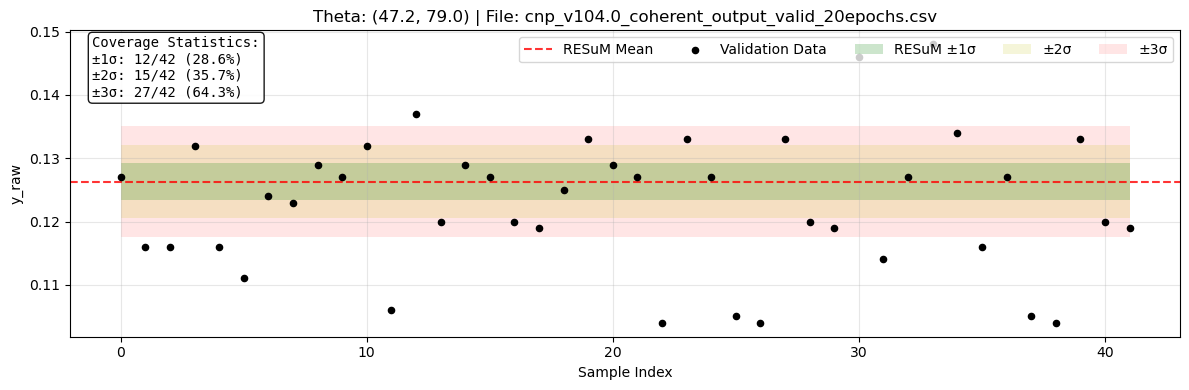

    Coverage statistics for Theta (47.2, 79.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 15/42 (35.7%)
    ±3σ: 27/42 (64.3%)
  Theta: (42.2, 84.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_42.2_84.0.png


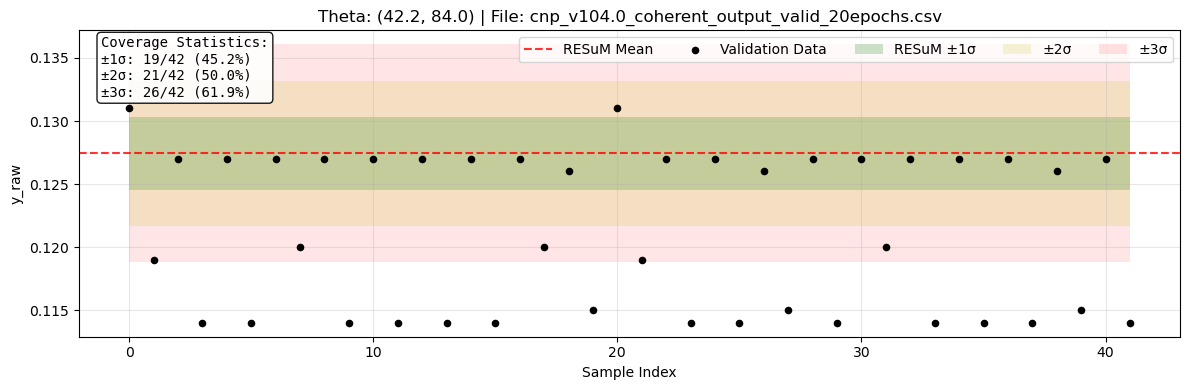

    Coverage statistics for Theta (42.2, 84.0):
    ±1σ: 19/42 (45.2%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 26/42 (61.9%)
  Theta: (72.2, 54.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_72.2_54.0.png


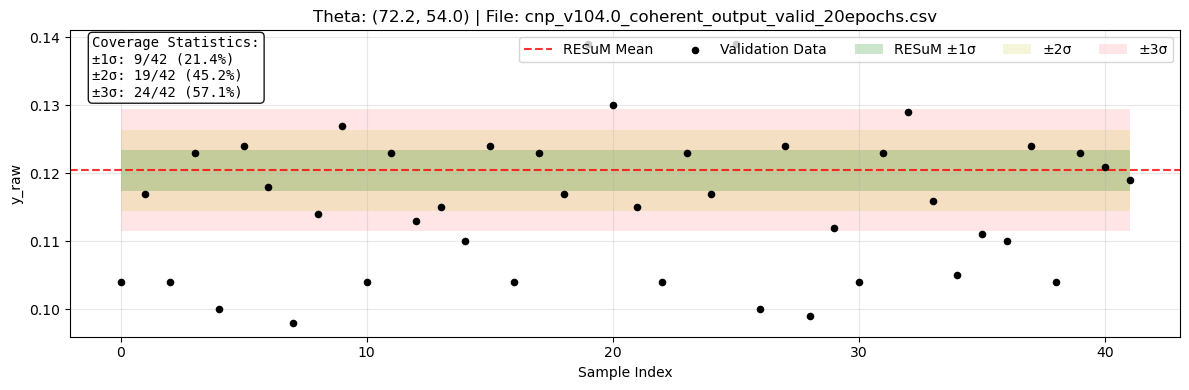

    Coverage statistics for Theta (72.2, 54.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 24/42 (57.1%)
  Theta: (75.2, 51.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_75.2_51.0.png


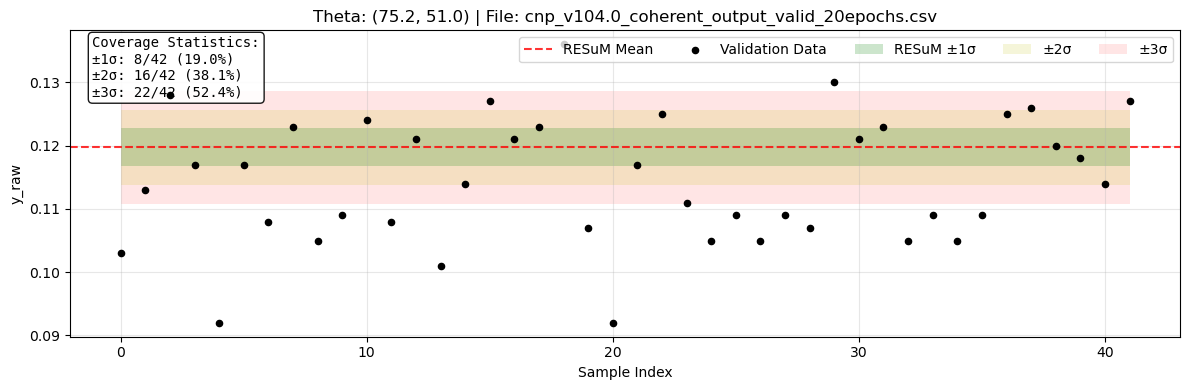

    Coverage statistics for Theta (75.2, 51.0):
    ±1σ: 8/42 (19.0%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 22/42 (52.4%)
  Theta: (87.2, 39.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_87.2_39.0.png


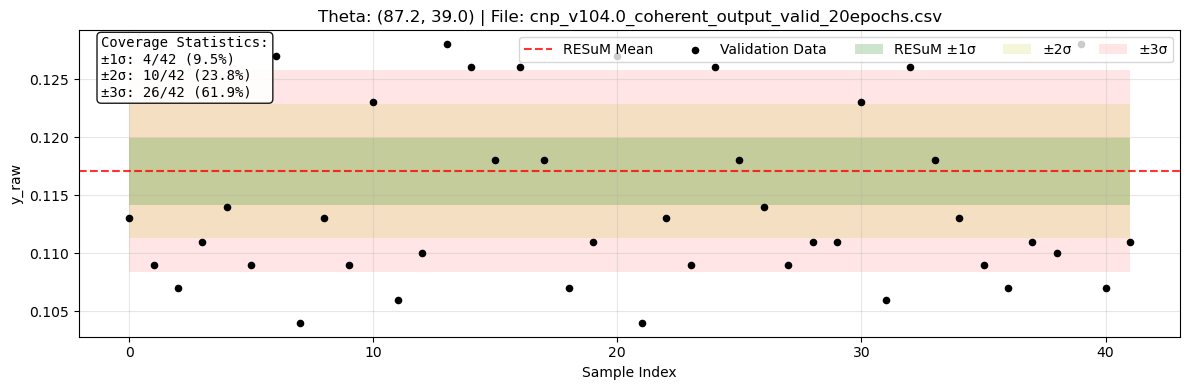

    Coverage statistics for Theta (87.2, 39.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 10/42 (23.8%)
    ±3σ: 26/42 (61.9%)
  Theta: (79.2, 47.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_79.2_47.0.png


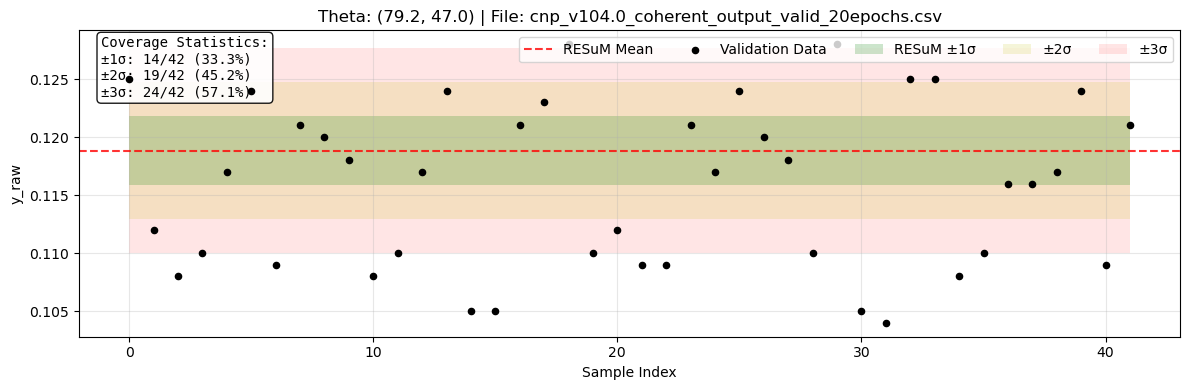

    Coverage statistics for Theta (79.2, 47.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 24/42 (57.1%)
  Theta: (59.2, 67.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_59.2_67.0.png


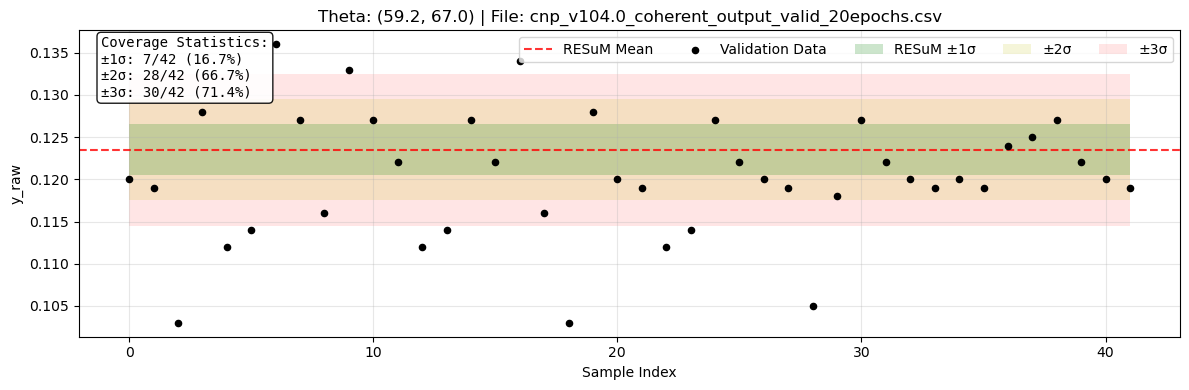

    Coverage statistics for Theta (59.2, 67.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 30/42 (71.4%)
  Theta: (37.2, 89.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_37.2_89.0.png


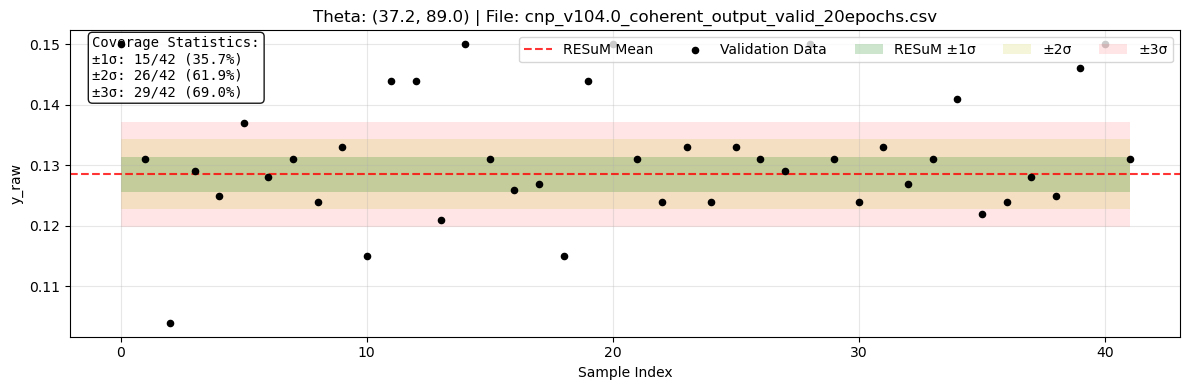

    Coverage statistics for Theta (37.2, 89.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 29/42 (69.0%)
  Theta: (90.2, 36.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_90.2_36.0.png


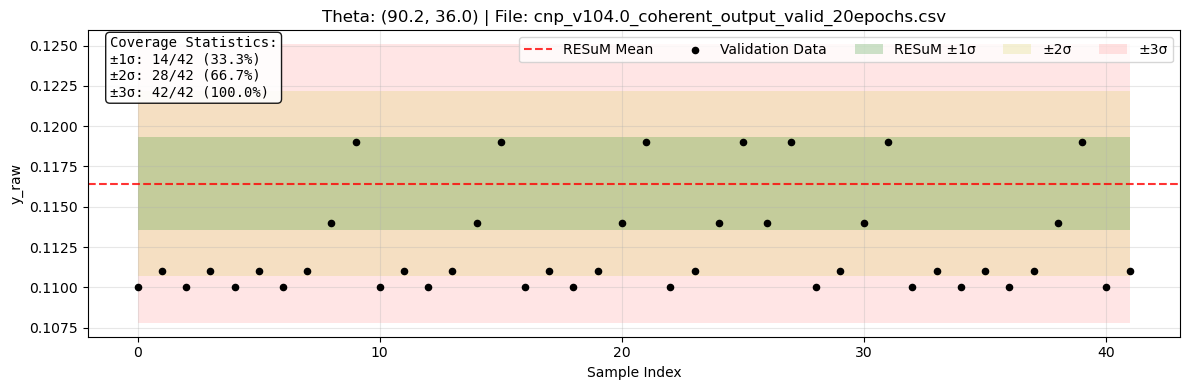

    Coverage statistics for Theta (90.2, 36.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 42/42 (100.0%)
  Theta: (38.2, 88.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_38.2_88.0.png


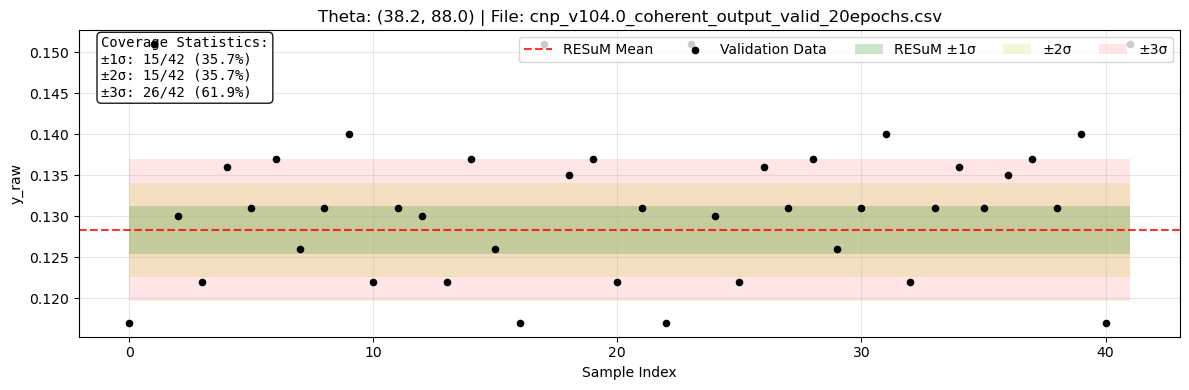

    Coverage statistics for Theta (38.2, 88.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 15/42 (35.7%)
    ±3σ: 26/42 (61.9%)
  Theta: (63.2, 63.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_63.2_63.0.png


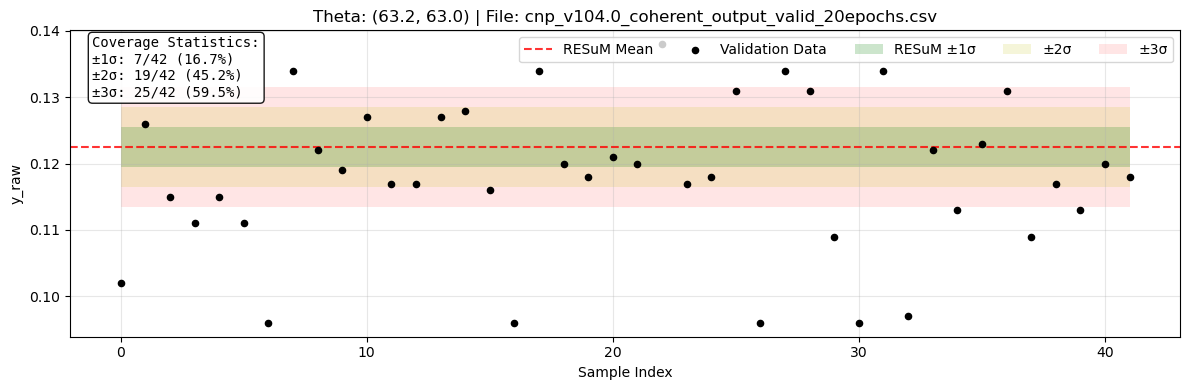

    Coverage statistics for Theta (63.2, 63.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 25/42 (59.5%)
  Theta: (107.2, 19.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_107.2_19.0.png


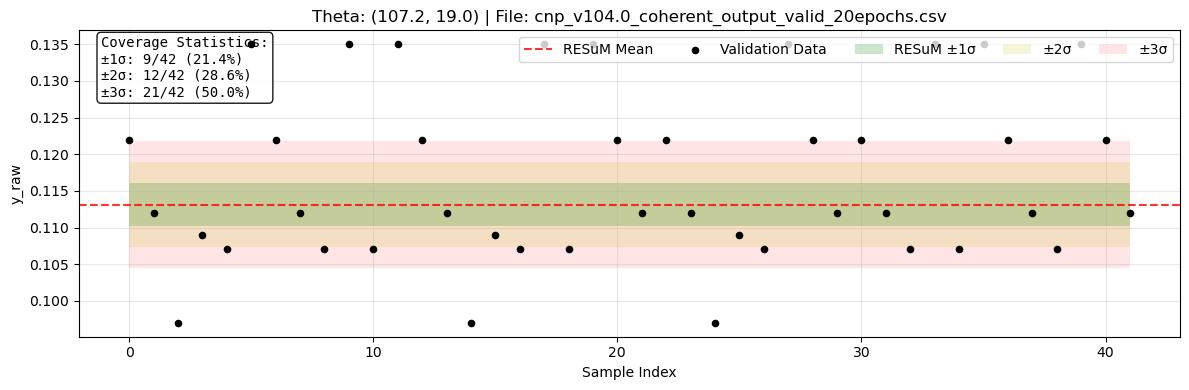

    Coverage statistics for Theta (107.2, 19.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 12/42 (28.6%)
    ±3σ: 21/42 (50.0%)
  Theta: (28.2, 98.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_28.2_98.0.png


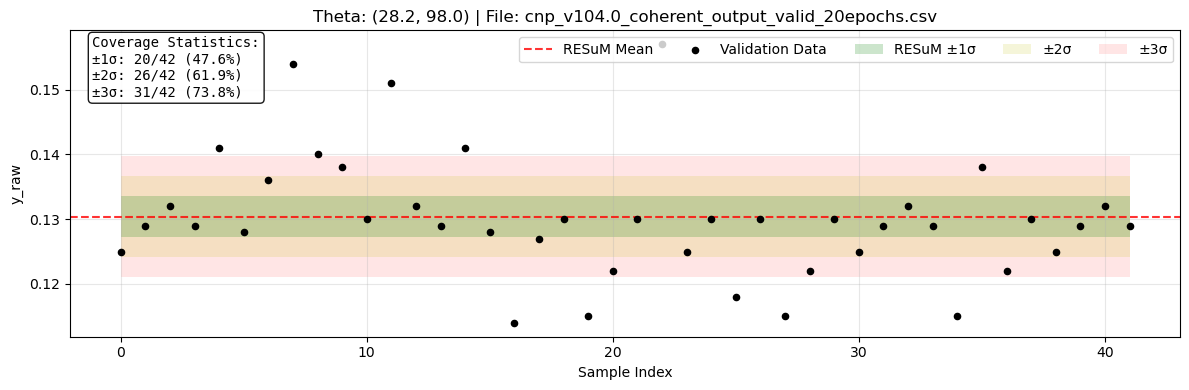

    Coverage statistics for Theta (28.2, 98.0):
    ±1σ: 20/42 (47.6%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 31/42 (73.8%)
  Theta: (45.2, 81.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_45.2_81.0.png


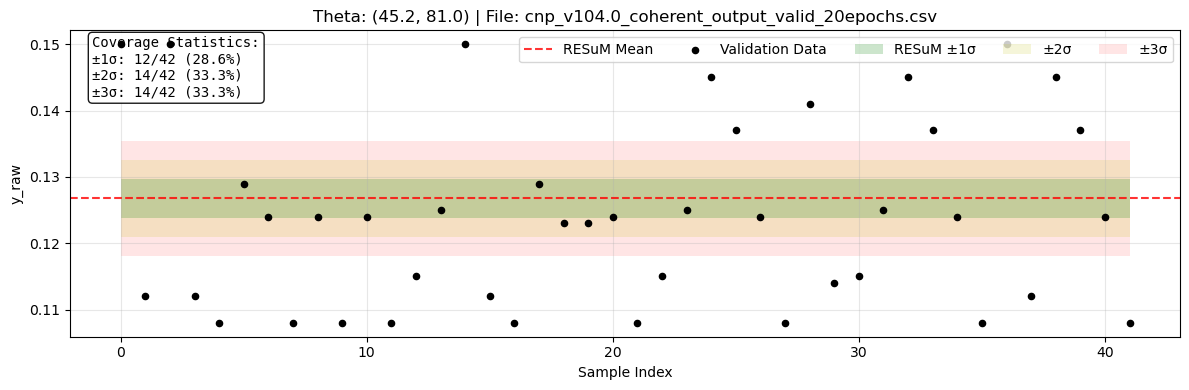

    Coverage statistics for Theta (45.2, 81.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 14/42 (33.3%)
    ±3σ: 14/42 (33.3%)
  Theta: (49.2, 77.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_49.2_77.0.png


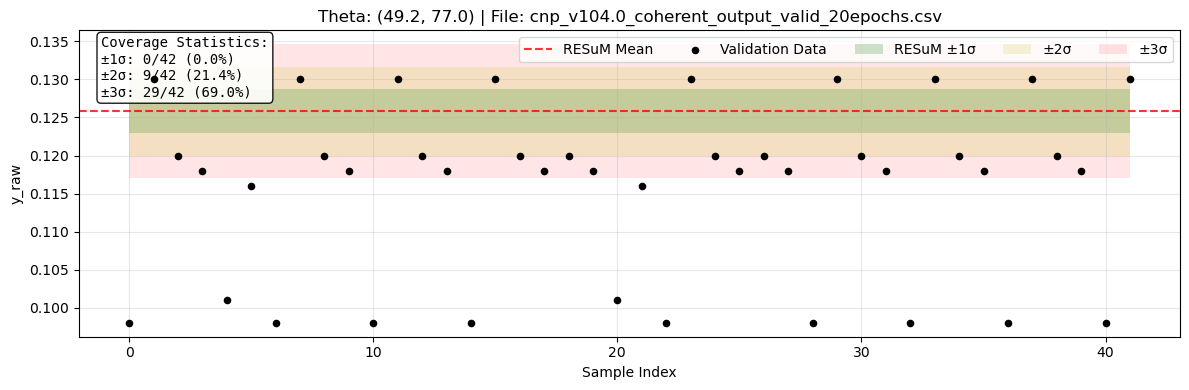

    Coverage statistics for Theta (49.2, 77.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 9/42 (21.4%)
    ±3σ: 29/42 (69.0%)
  Theta: (68.2, 58.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_68.2_58.0.png


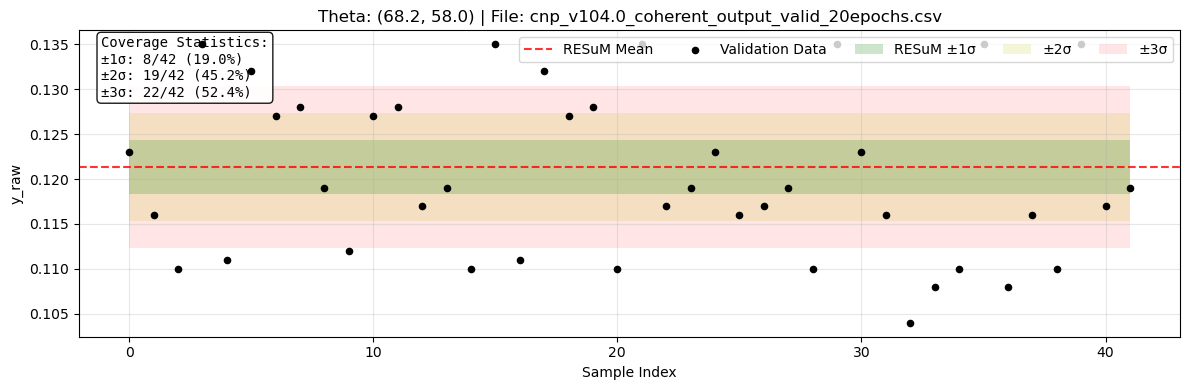

    Coverage statistics for Theta (68.2, 58.0):
    ±1σ: 8/42 (19.0%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 22/42 (52.4%)
  Theta: (110.2, 16.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_110.2_16.0.png


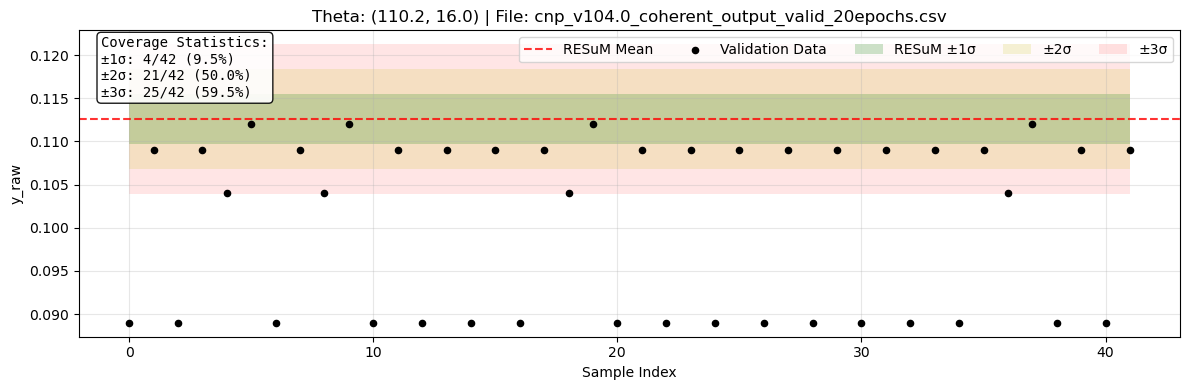

    Coverage statistics for Theta (110.2, 16.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 25/42 (59.5%)
  Theta: (69.2, 57.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_69.2_57.0.png


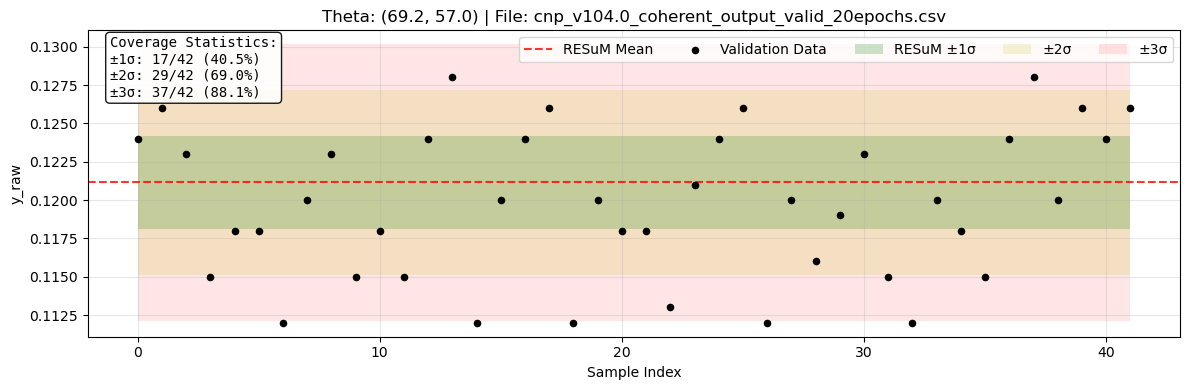

    Coverage statistics for Theta (69.2, 57.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 37/42 (88.1%)
  Theta: (53.2, 73.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_53.2_73.0.png


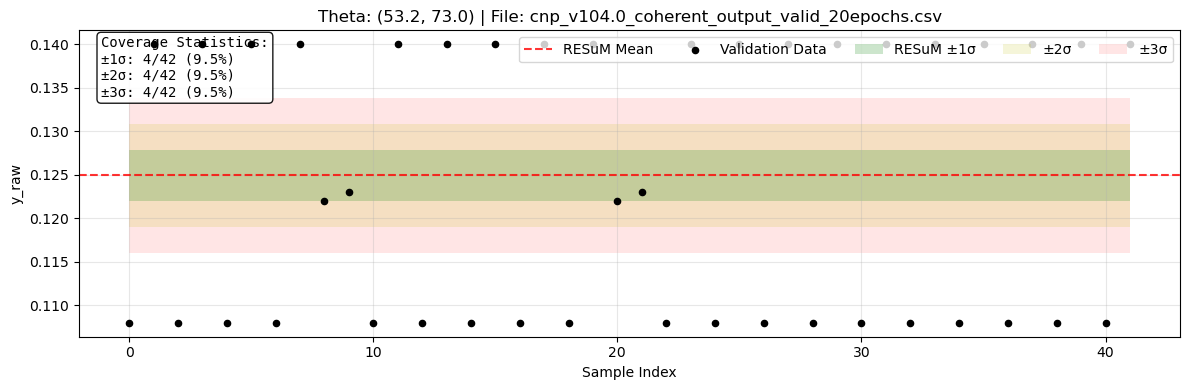

    Coverage statistics for Theta (53.2, 73.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 4/42 (9.5%)
    ±3σ: 4/42 (9.5%)
  Theta: (60.2, 66.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_60.2_66.0.png


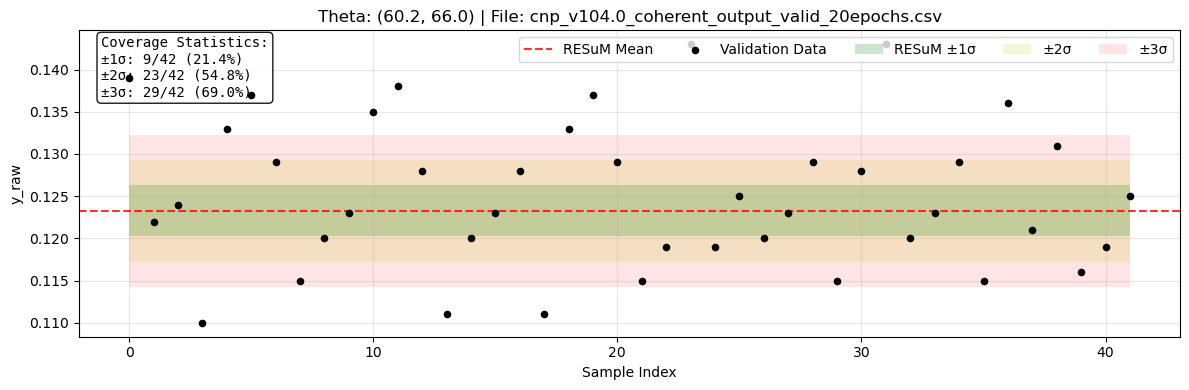

    Coverage statistics for Theta (60.2, 66.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 29/42 (69.0%)
  Theta: (31.2, 95.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_31.2_95.0.png


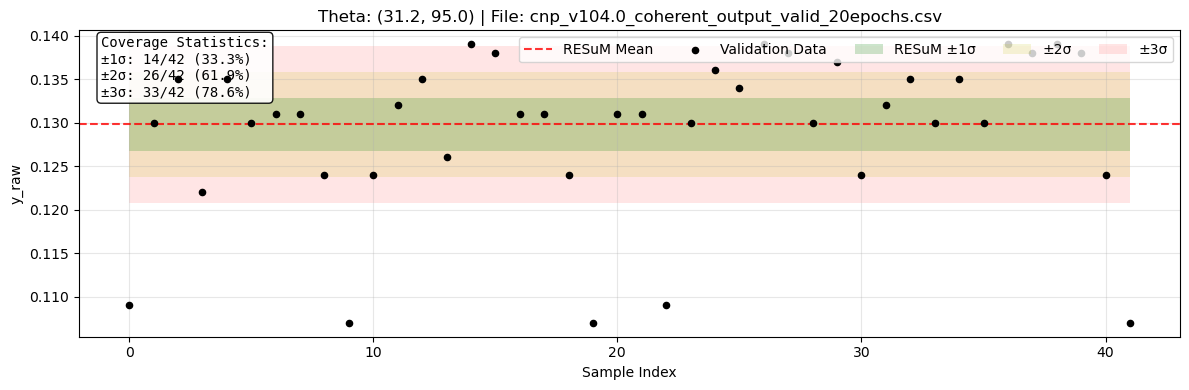

    Coverage statistics for Theta (31.2, 95.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 26/42 (61.9%)
    ±3σ: 33/42 (78.6%)
  Theta: (85.2, 41.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_85.2_41.0.png


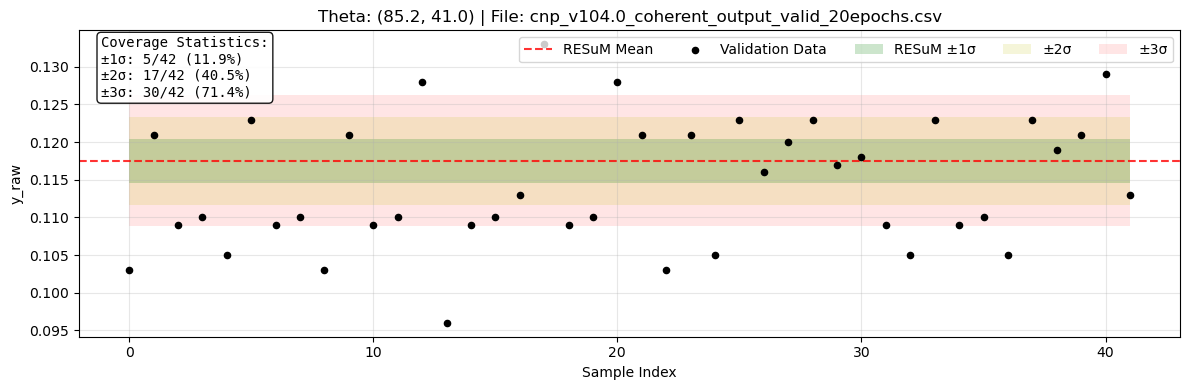

    Coverage statistics for Theta (85.2, 41.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 17/42 (40.5%)
    ±3σ: 30/42 (71.4%)
  Theta: (21.2, 105.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_21.2_105.0.png


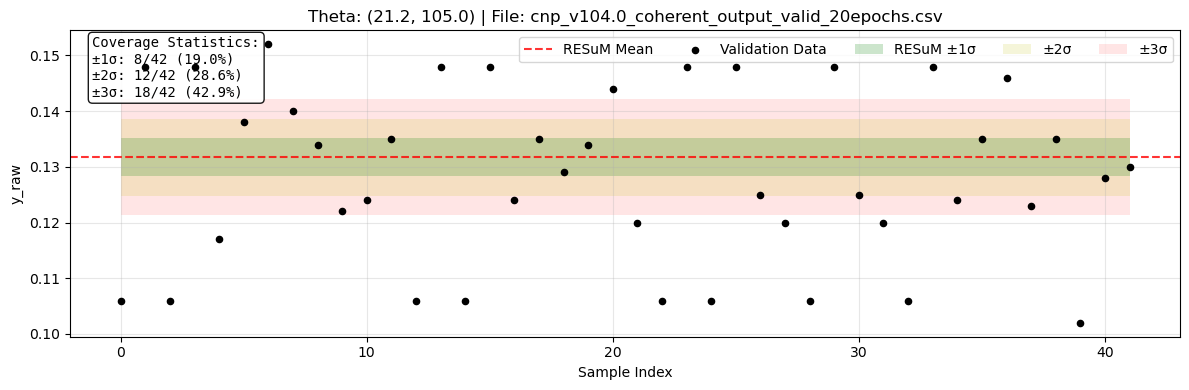

    Coverage statistics for Theta (21.2, 105.0):
    ±1σ: 8/42 (19.0%)
    ±2σ: 12/42 (28.6%)
    ±3σ: 18/42 (42.9%)
  Theta: (99.2, 27.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_99.2_27.0.png


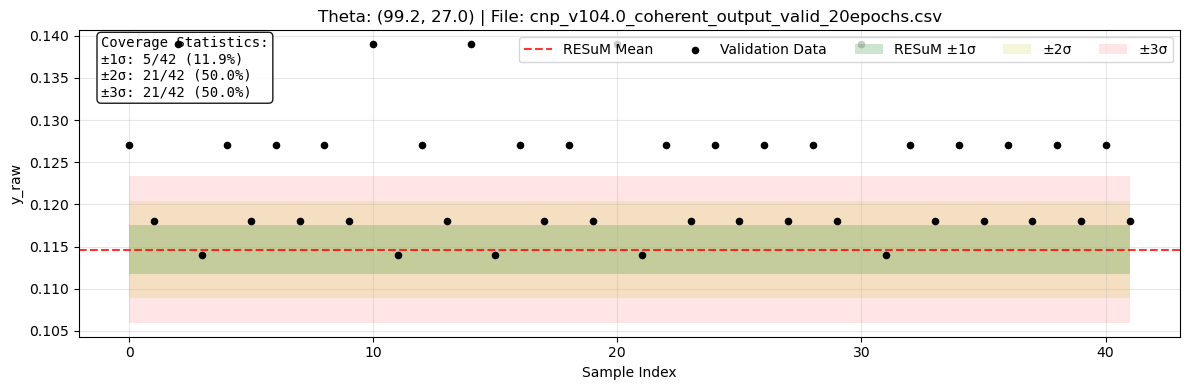

    Coverage statistics for Theta (99.2, 27.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (64.2, 62.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_64.2_62.0.png


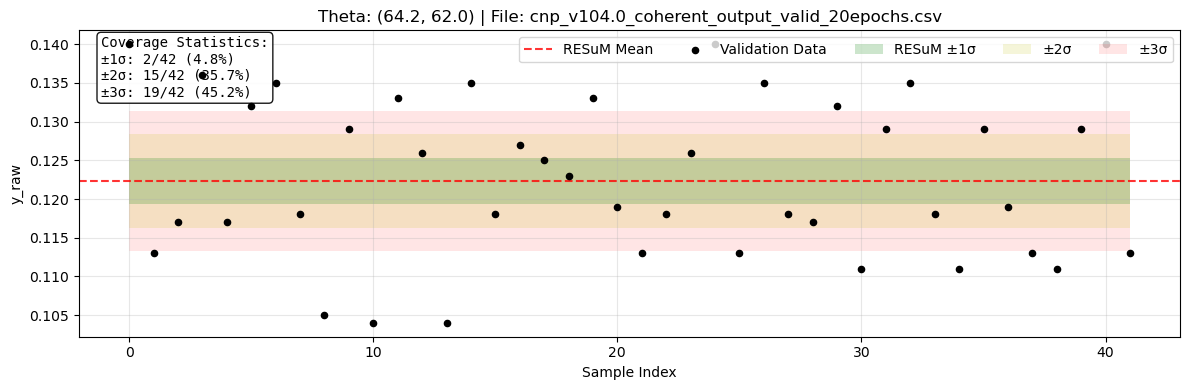

    Coverage statistics for Theta (64.2, 62.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 15/42 (35.7%)
    ±3σ: 19/42 (45.2%)
  Theta: (25.2, 101.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_25.2_101.0.png


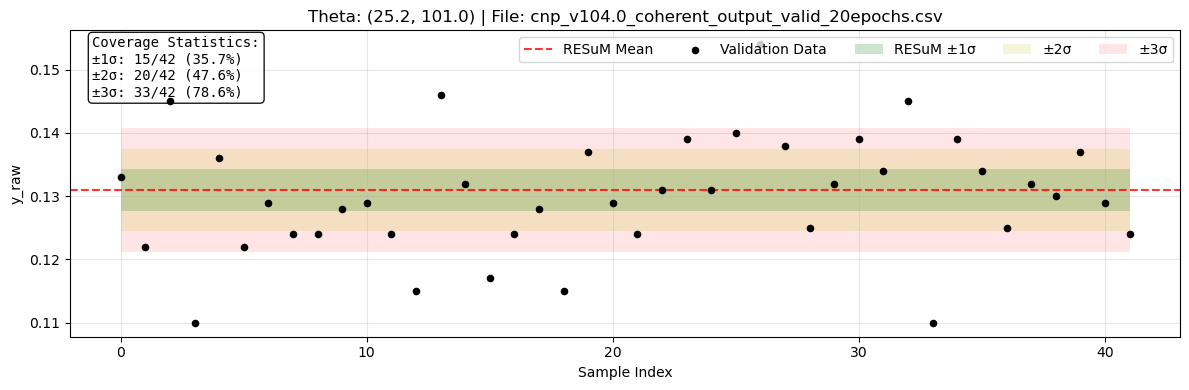

    Coverage statistics for Theta (25.2, 101.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 20/42 (47.6%)
    ±3σ: 33/42 (78.6%)
  Theta: (65.2, 61.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_65.2_61.0.png


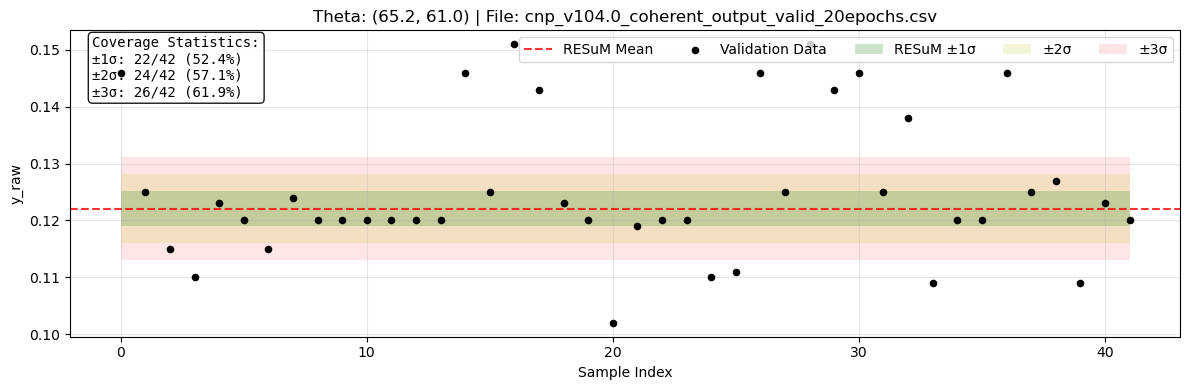

    Coverage statistics for Theta (65.2, 61.0):
    ±1σ: 22/42 (52.4%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 26/42 (61.9%)
  Theta: (111.2, 15.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_111.2_15.0.png


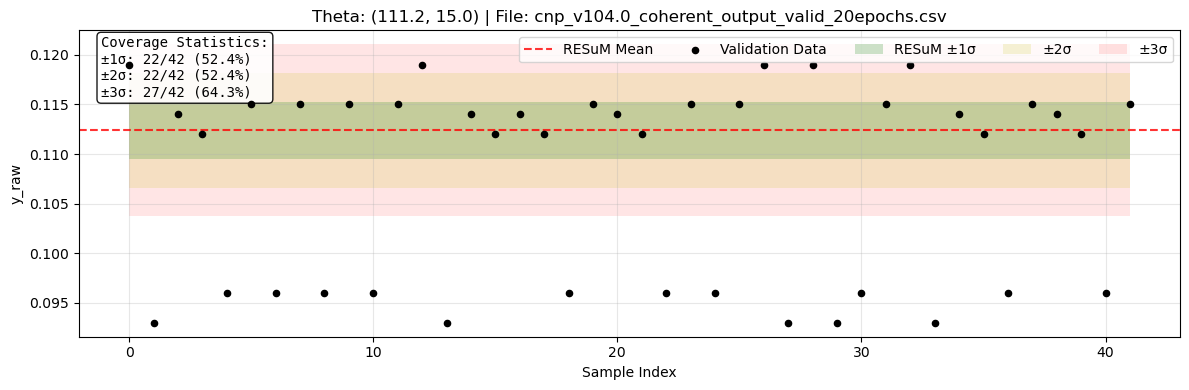

    Coverage statistics for Theta (111.2, 15.0):
    ±1σ: 22/42 (52.4%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 27/42 (64.3%)
  Theta: (73.2, 53.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_73.2_53.0.png


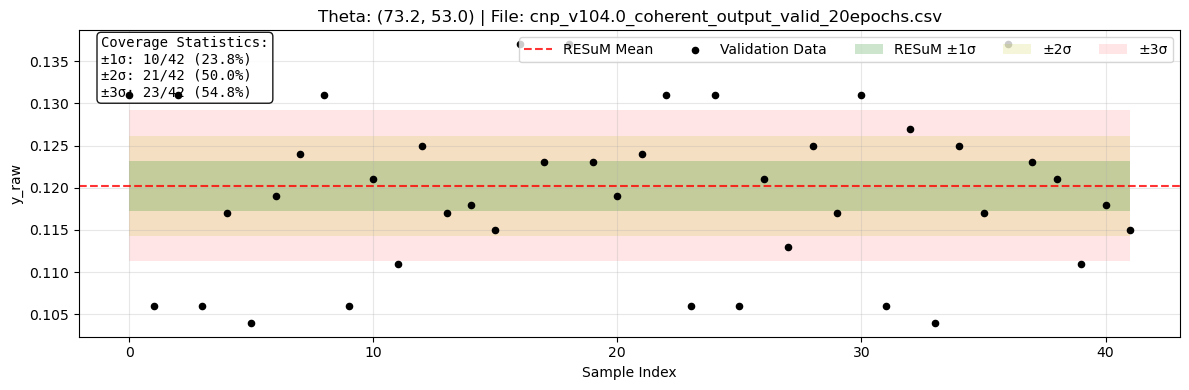

    Coverage statistics for Theta (73.2, 53.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 23/42 (54.8%)
  Theta: (50.2, 76.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_50.2_76.0.png


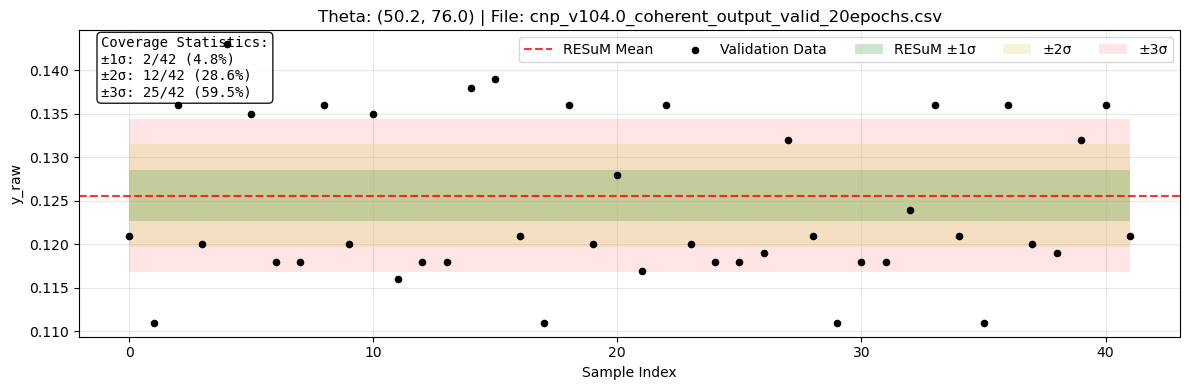

    Coverage statistics for Theta (50.2, 76.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 12/42 (28.6%)
    ±3σ: 25/42 (59.5%)
  Theta: (67.2, 59.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_67.2_59.0.png


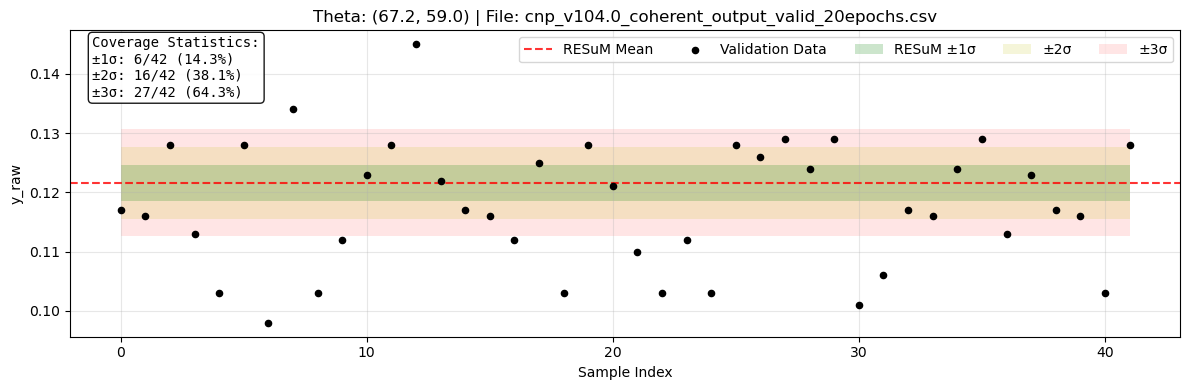

    Coverage statistics for Theta (67.2, 59.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 27/42 (64.3%)
  Theta: (18.2, 108.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_18.2_108.0.png


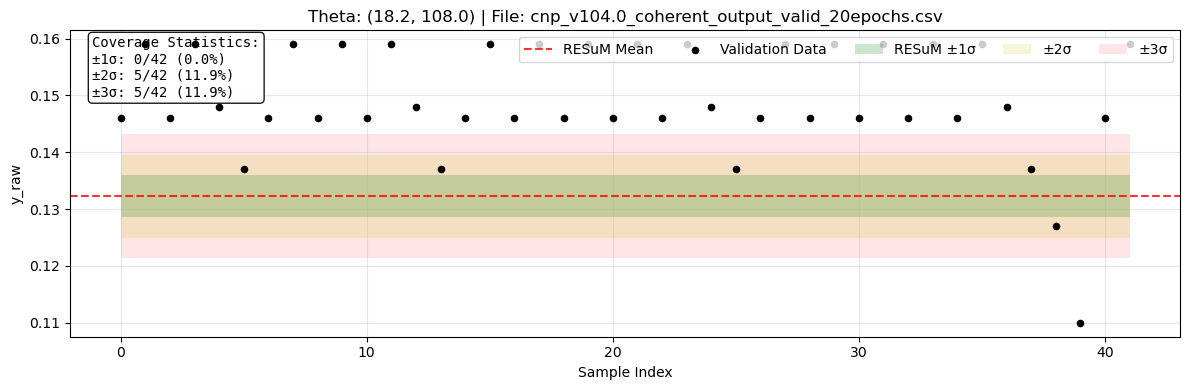

    Coverage statistics for Theta (18.2, 108.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 5/42 (11.9%)
    ±3σ: 5/42 (11.9%)
  Theta: (62.2, 64.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_62.2_64.0.png


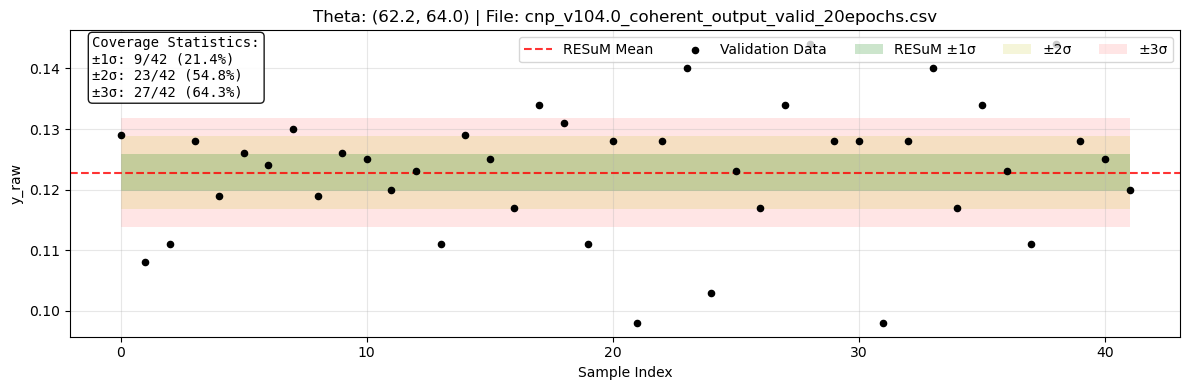

    Coverage statistics for Theta (62.2, 64.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 27/42 (64.3%)
  Theta: (109.2, 17.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_109.2_17.0.png


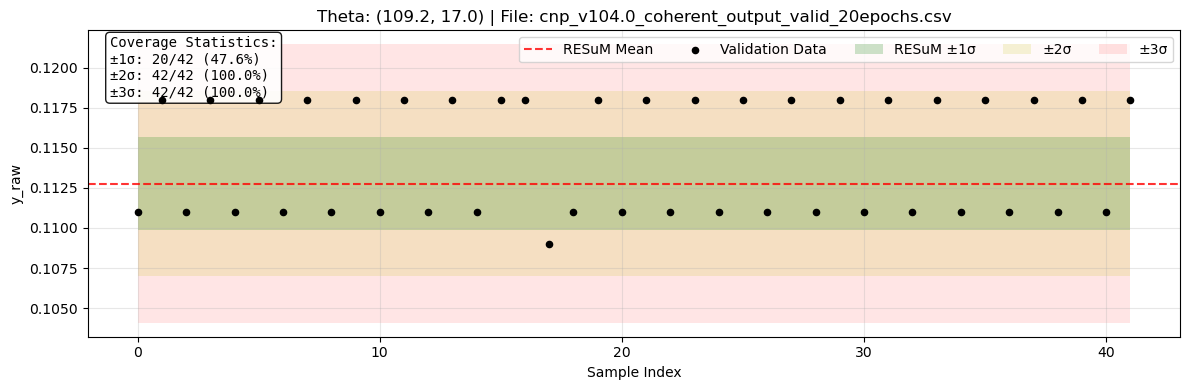

    Coverage statistics for Theta (109.2, 17.0):
    ±1σ: 20/42 (47.6%)
    ±2σ: 42/42 (100.0%)
    ±3σ: 42/42 (100.0%)
  Theta: (94.2, 32.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_94.2_32.0.png


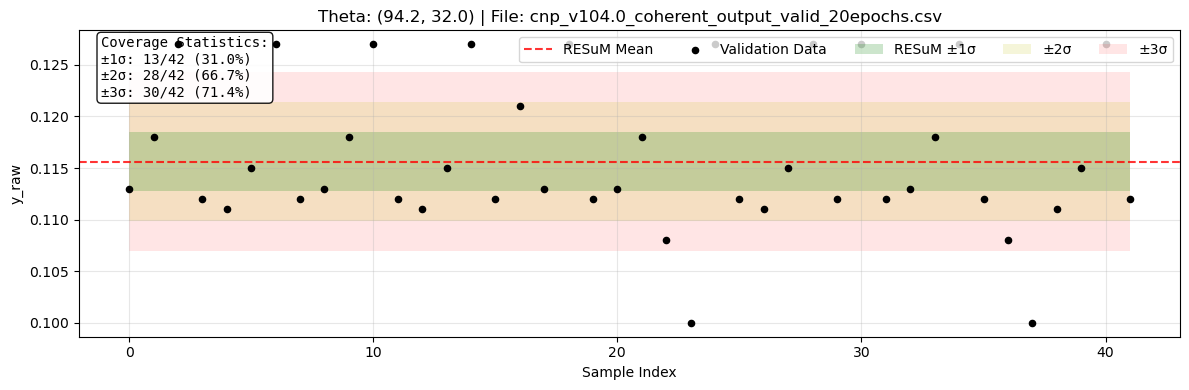

    Coverage statistics for Theta (94.2, 32.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 30/42 (71.4%)
  Theta: (82.2, 44.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_82.2_44.0.png


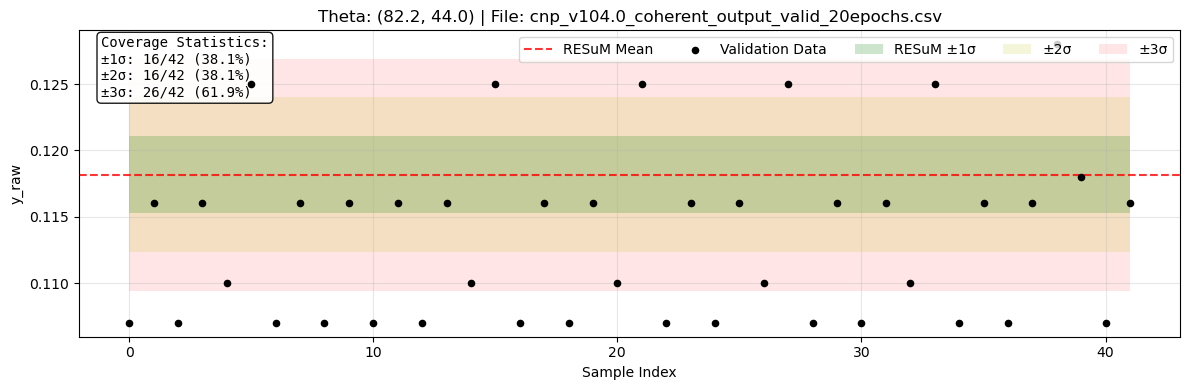

    Coverage statistics for Theta (82.2, 44.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 26/42 (61.9%)
  Theta: (115.2, 11.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_115.2_11.0.png


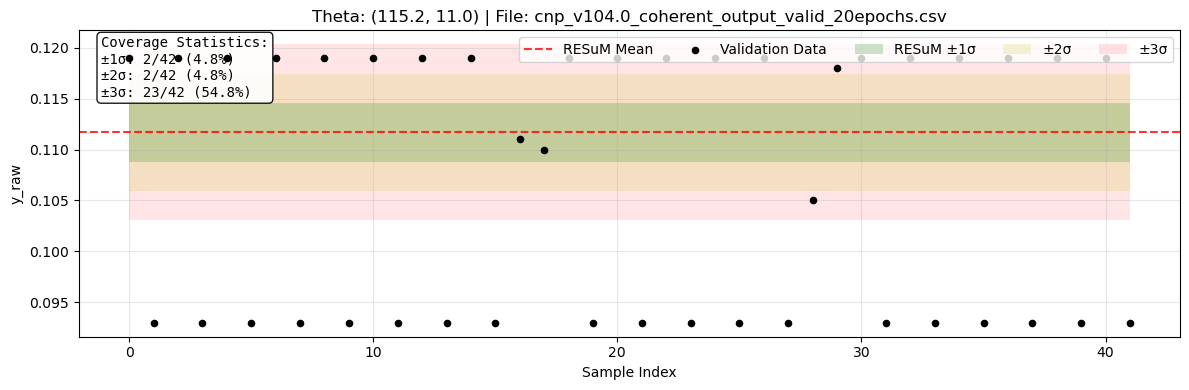

    Coverage statistics for Theta (115.2, 11.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 2/42 (4.8%)
    ±3σ: 23/42 (54.8%)
  Theta: (34.2, 92.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_34.2_92.0.png


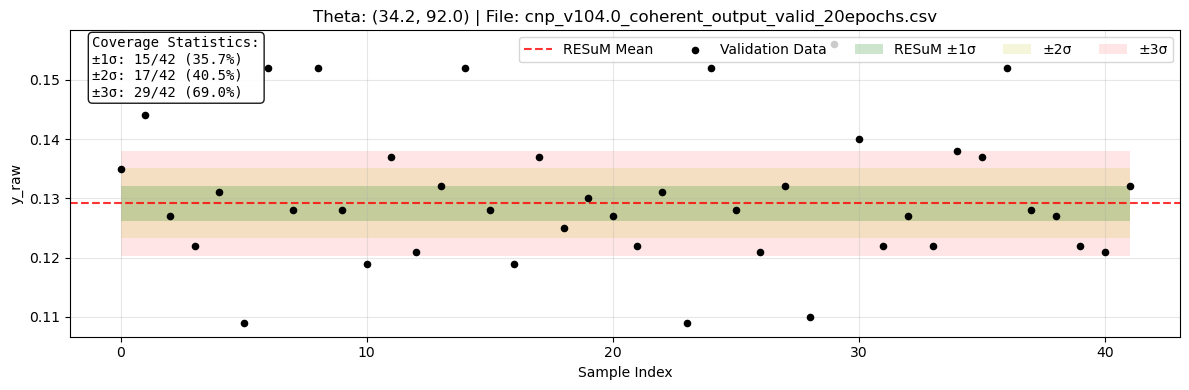

    Coverage statistics for Theta (34.2, 92.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 17/42 (40.5%)
    ±3σ: 29/42 (69.0%)
  Theta: (55.2, 71.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_55.2_71.0.png


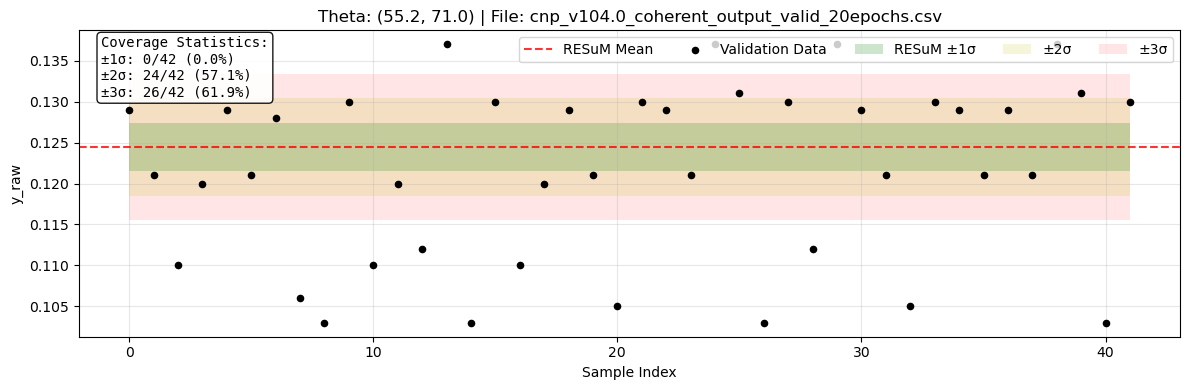

    Coverage statistics for Theta (55.2, 71.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 26/42 (61.9%)
  Theta: (57.2, 69.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_57.2_69.0.png


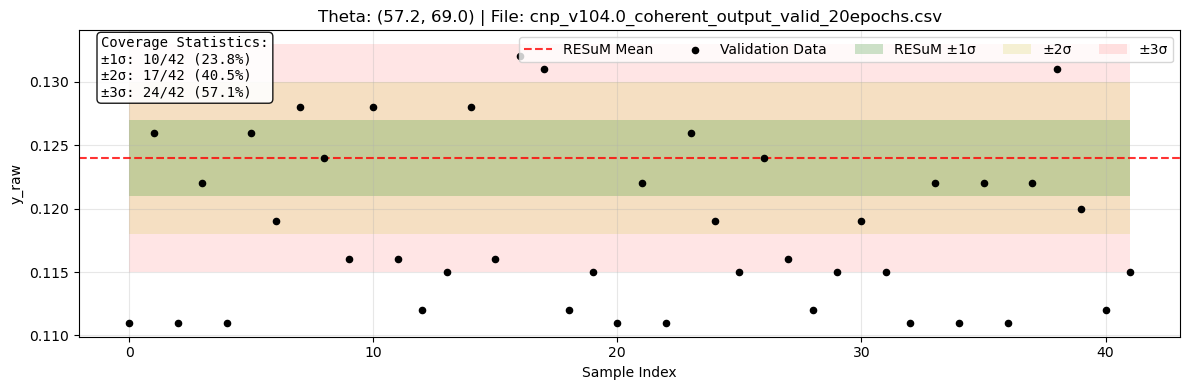

    Coverage statistics for Theta (57.2, 69.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 17/42 (40.5%)
    ±3σ: 24/42 (57.1%)
  Theta: (100.2, 26.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_100.2_26.0.png


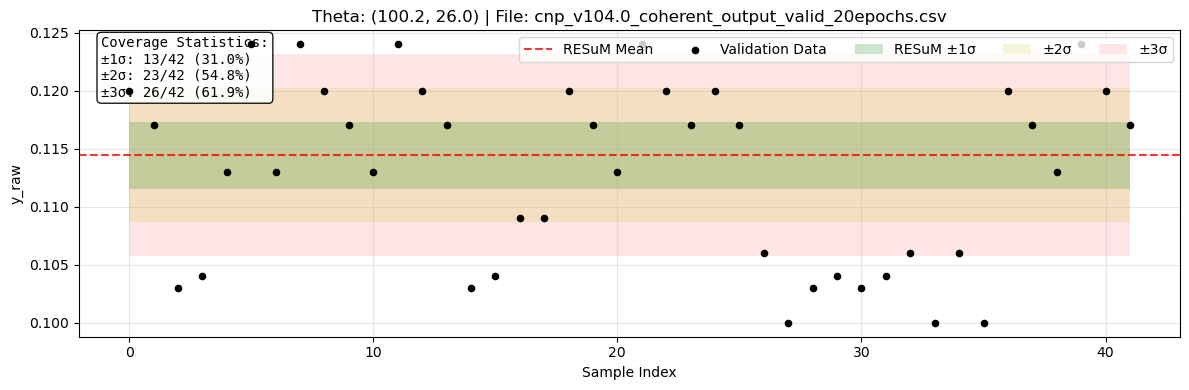

    Coverage statistics for Theta (100.2, 26.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 26/42 (61.9%)
  Theta: (71.2, 55.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_71.2_55.0.png


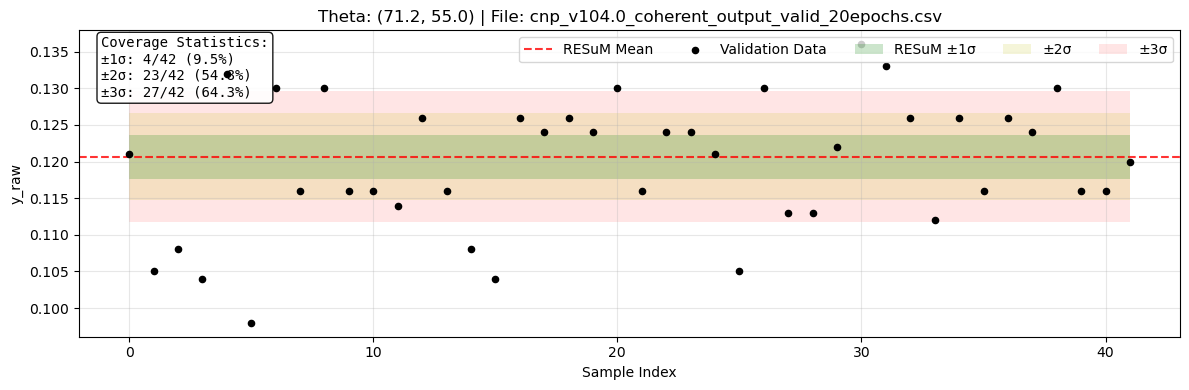

    Coverage statistics for Theta (71.2, 55.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 27/42 (64.3%)
  Theta: (33.2, 93.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_33.2_93.0.png


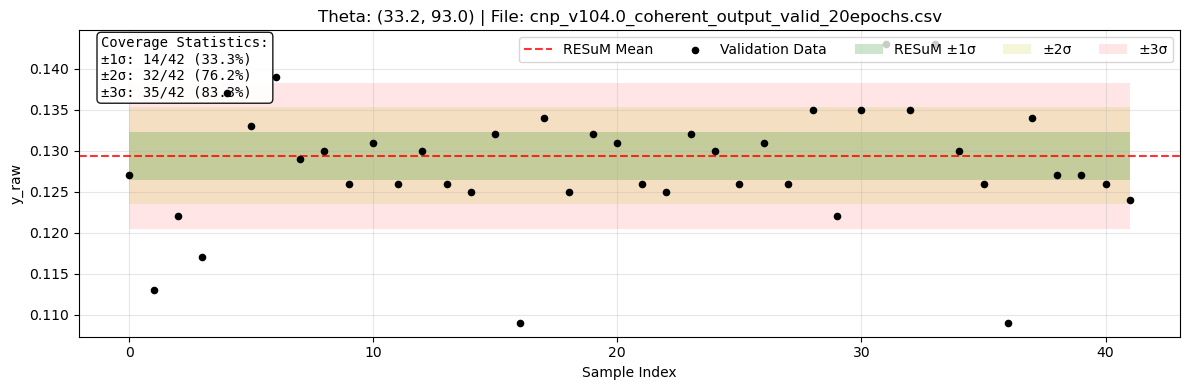

    Coverage statistics for Theta (33.2, 93.0):
    ±1σ: 14/42 (33.3%)
    ±2σ: 32/42 (76.2%)
    ±3σ: 35/42 (83.3%)
  Theta: (105.2, 21.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_105.2_21.0.png


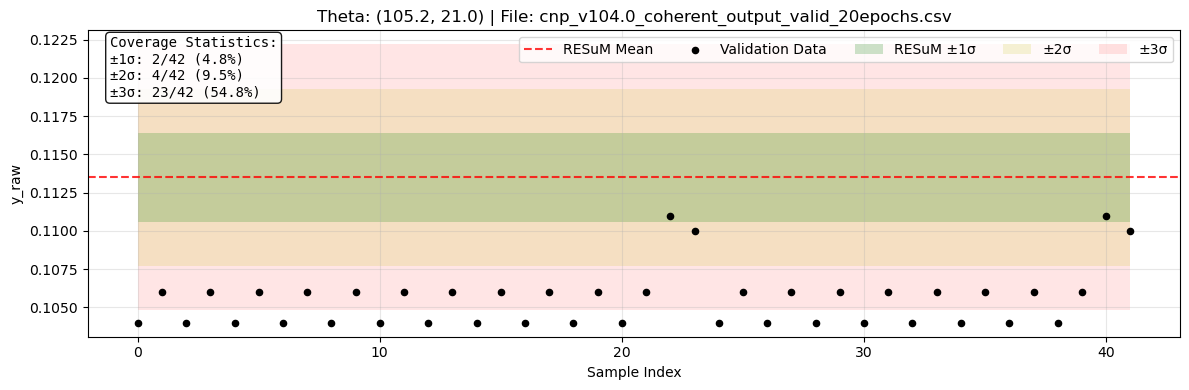

    Coverage statistics for Theta (105.2, 21.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 4/42 (9.5%)
    ±3σ: 23/42 (54.8%)
  Theta: (89.2, 37.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_89.2_37.0.png


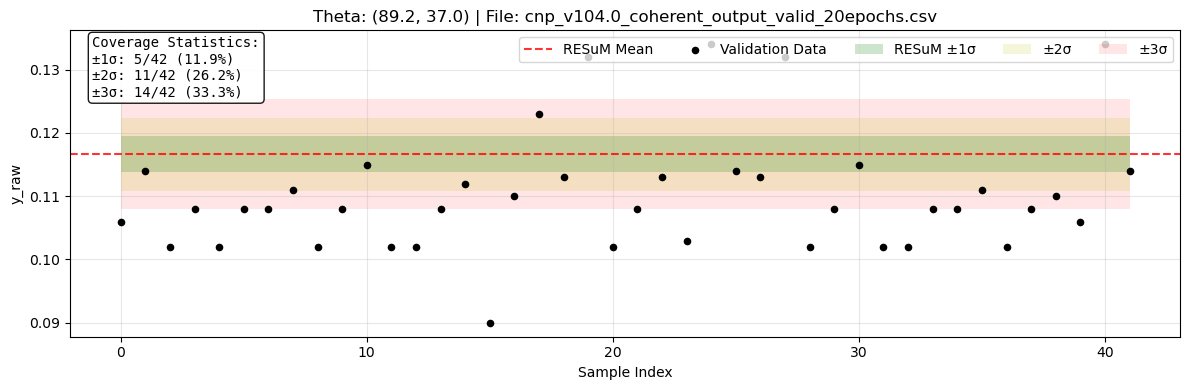

    Coverage statistics for Theta (89.2, 37.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 11/42 (26.2%)
    ±3σ: 14/42 (33.3%)
  Theta: (113.2, 13.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_113.2_13.0.png


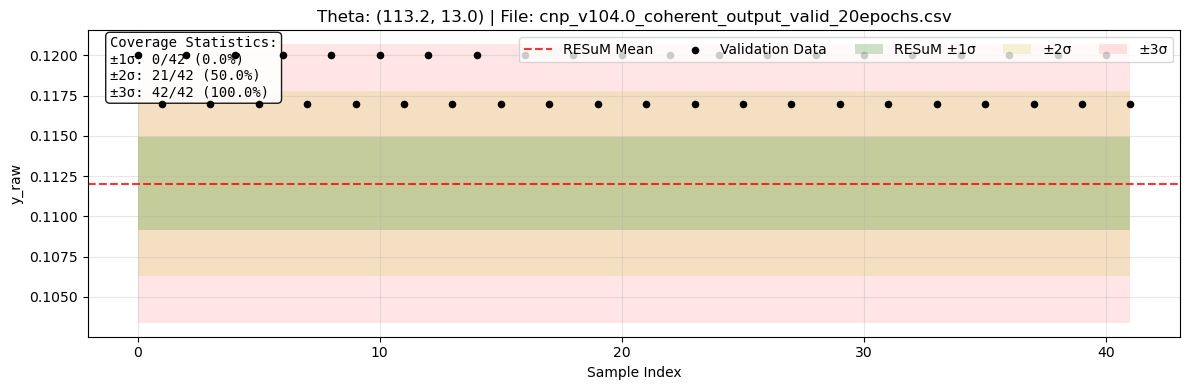

    Coverage statistics for Theta (113.2, 13.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 42/42 (100.0%)
  Theta: (58.2, 68.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_58.2_68.0.png


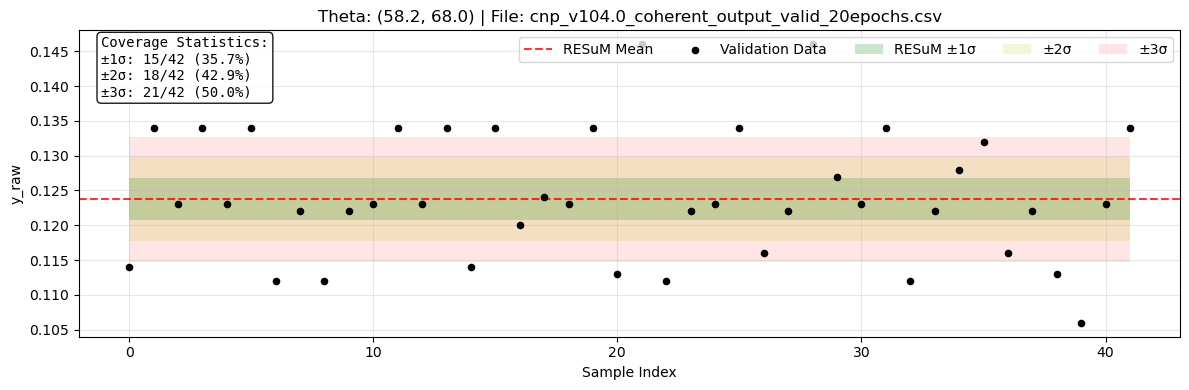

    Coverage statistics for Theta (58.2, 68.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 18/42 (42.9%)
    ±3σ: 21/42 (50.0%)
  Theta: (83.2, 43.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_83.2_43.0.png


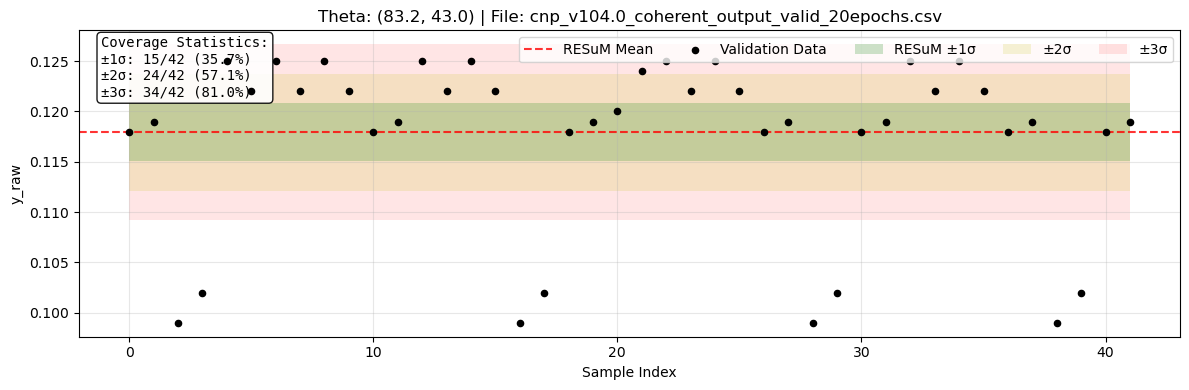

    Coverage statistics for Theta (83.2, 43.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 34/42 (81.0%)
  Theta: (44.2, 82.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_44.2_82.0.png


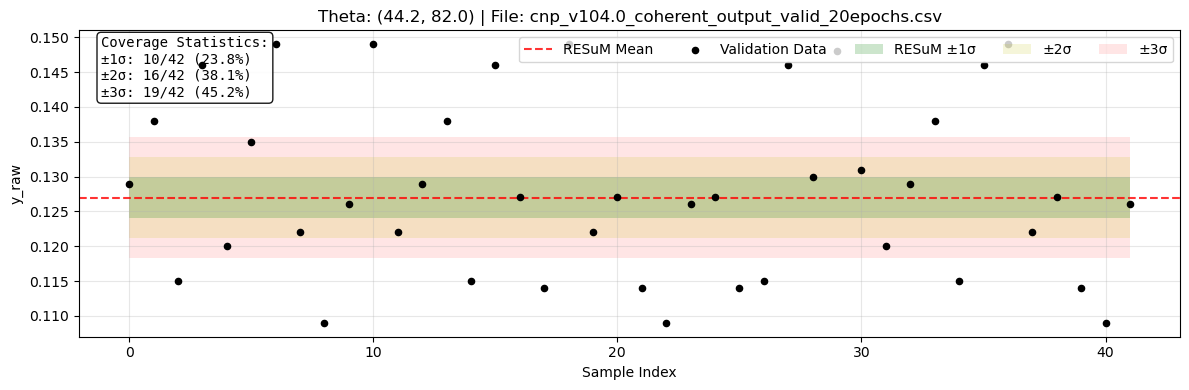

    Coverage statistics for Theta (44.2, 82.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 19/42 (45.2%)
  Theta: (81.2, 45.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_81.2_45.0.png


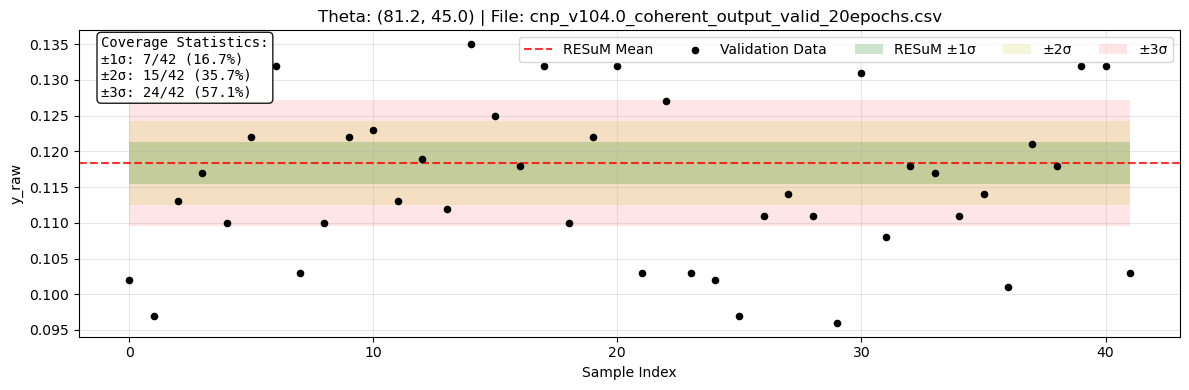

    Coverage statistics for Theta (81.2, 45.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 15/42 (35.7%)
    ±3σ: 24/42 (57.1%)
  Theta: (102.2, 24.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_102.2_24.0.png


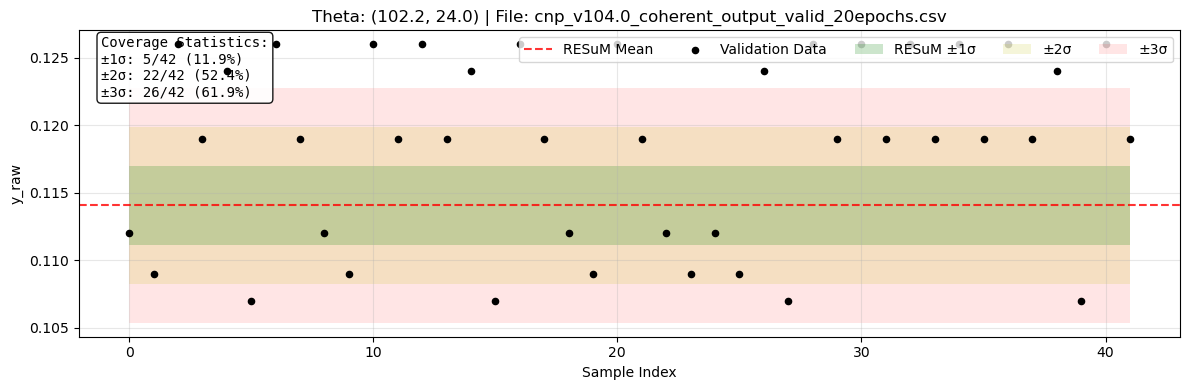

    Coverage statistics for Theta (102.2, 24.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 26/42 (61.9%)
  Theta: (101.2, 25.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_101.2_25.0.png


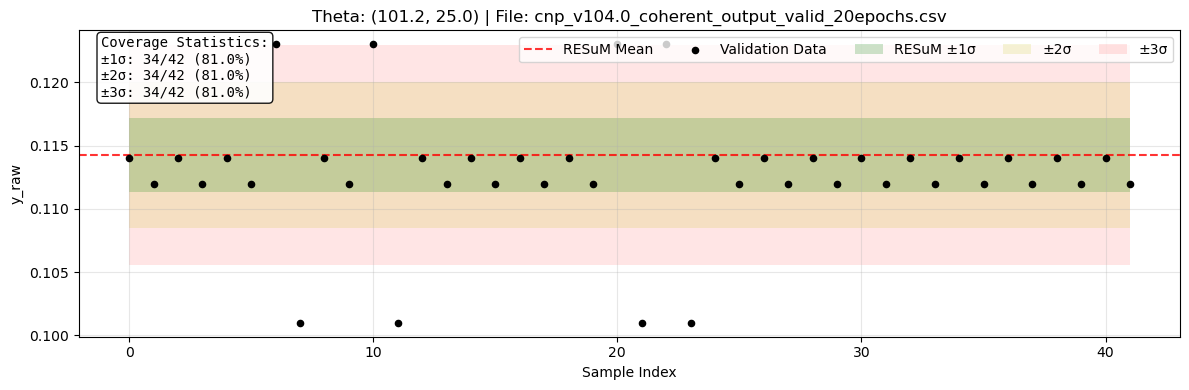

    Coverage statistics for Theta (101.2, 25.0):
    ±1σ: 34/42 (81.0%)
    ±2σ: 34/42 (81.0%)
    ±3σ: 34/42 (81.0%)
  Theta: (39.2, 87.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_39.2_87.0.png


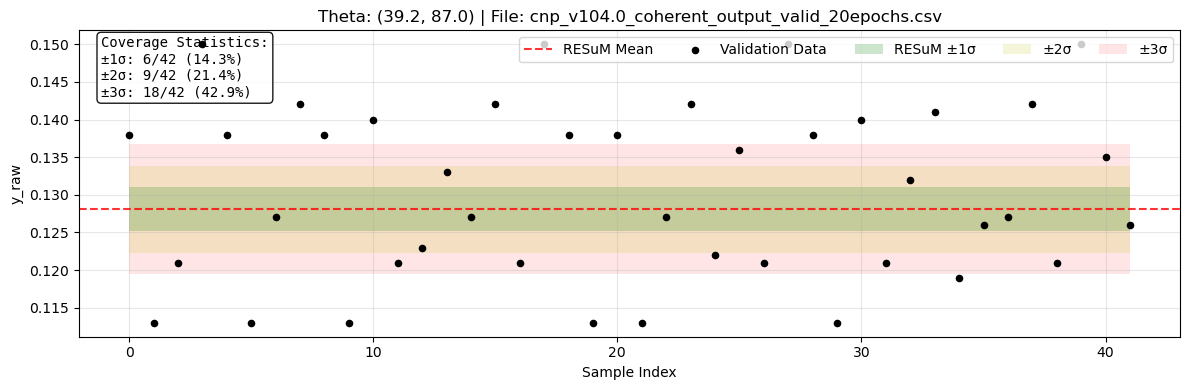

    Coverage statistics for Theta (39.2, 87.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 9/42 (21.4%)
    ±3σ: 18/42 (42.9%)
  Theta: (43.2, 83.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_43.2_83.0.png


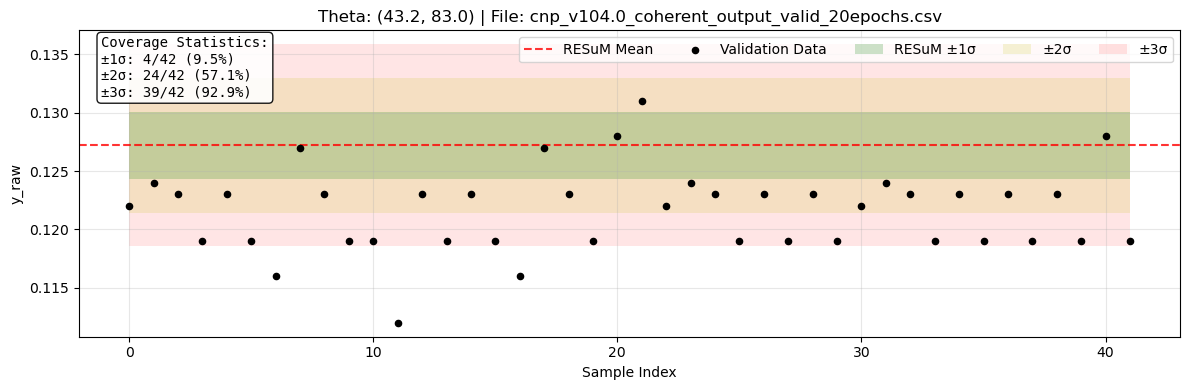

    Coverage statistics for Theta (43.2, 83.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 24/42 (57.1%)
    ±3σ: 39/42 (92.9%)
  Theta: (24.2, 102.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_24.2_102.0.png


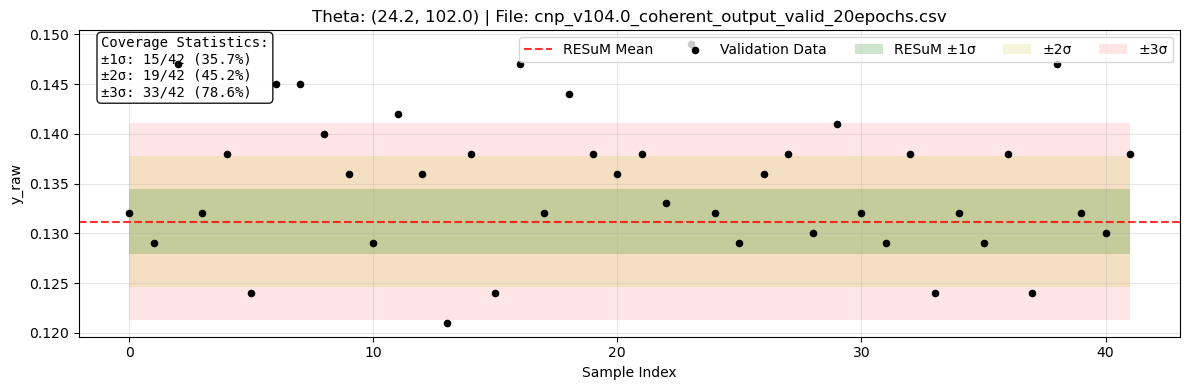

    Coverage statistics for Theta (24.2, 102.0):
    ±1σ: 15/42 (35.7%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 33/42 (78.6%)
  Theta: (98.2, 28.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_98.2_28.0.png


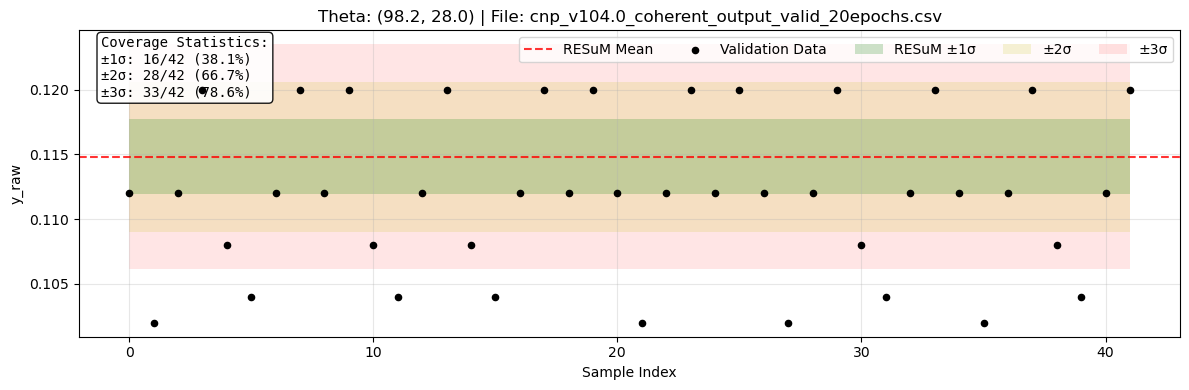

    Coverage statistics for Theta (98.2, 28.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 28/42 (66.7%)
    ±3σ: 33/42 (78.6%)
  Theta: (108.2, 18.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_108.2_18.0.png


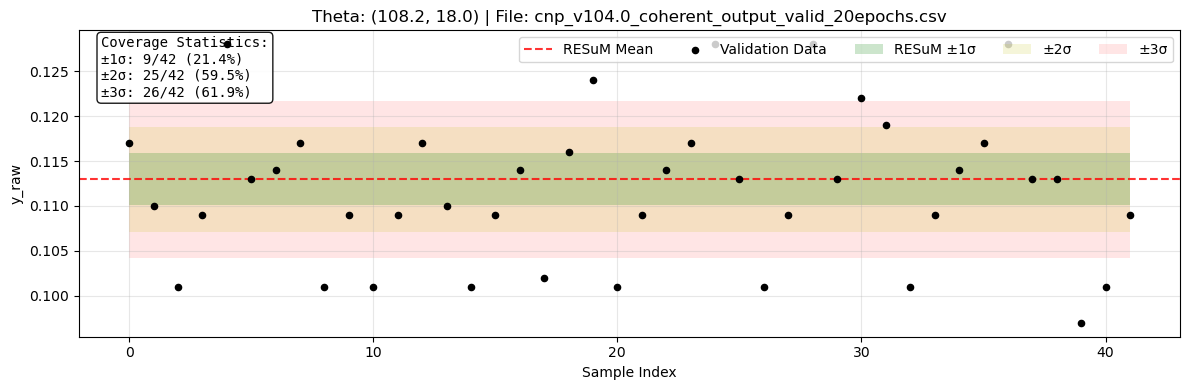

    Coverage statistics for Theta (108.2, 18.0):
    ±1σ: 9/42 (21.4%)
    ±2σ: 25/42 (59.5%)
    ±3σ: 26/42 (61.9%)
  Theta: (84.2, 42.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_84.2_42.0.png


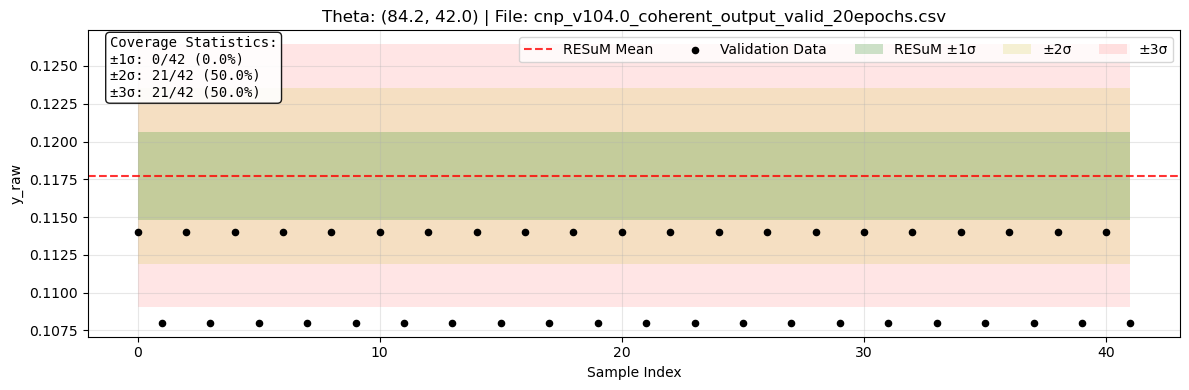

    Coverage statistics for Theta (84.2, 42.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (32.2, 94.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_32.2_94.0.png


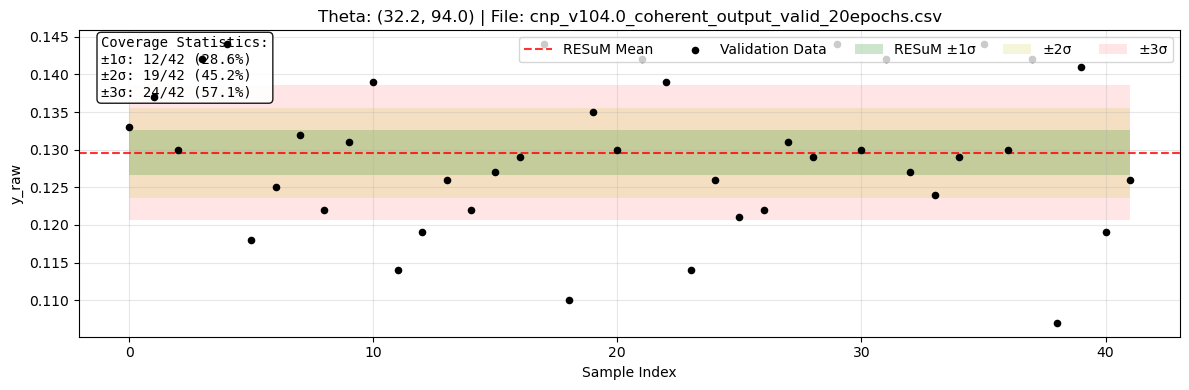

    Coverage statistics for Theta (32.2, 94.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 19/42 (45.2%)
    ±3σ: 24/42 (57.1%)
  Theta: (61.2, 65.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_61.2_65.0.png


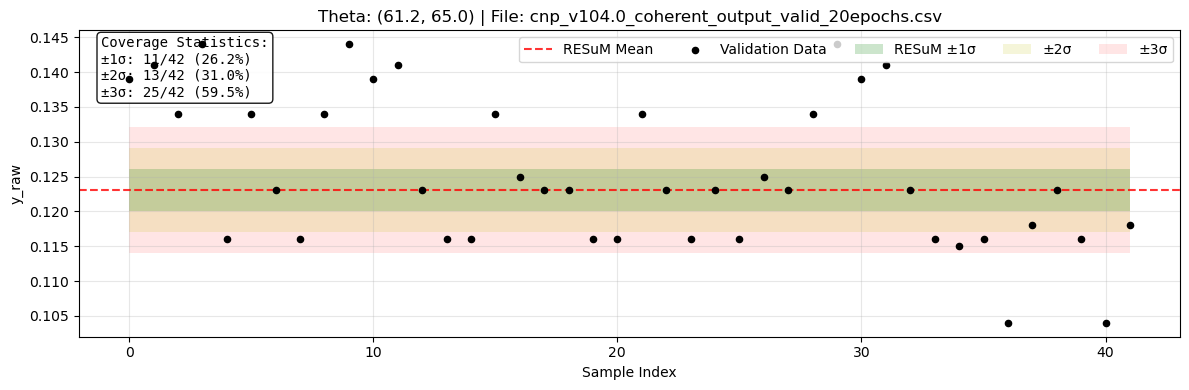

    Coverage statistics for Theta (61.2, 65.0):
    ±1σ: 11/42 (26.2%)
    ±2σ: 13/42 (31.0%)
    ±3σ: 25/42 (59.5%)
  Theta: (97.2, 29.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_97.2_29.0.png


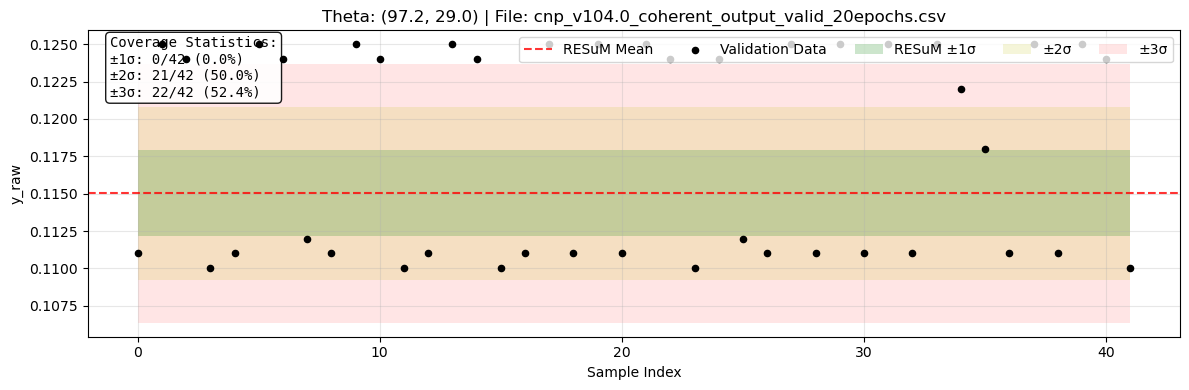

    Coverage statistics for Theta (97.2, 29.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 22/42 (52.4%)
  Theta: (54.2, 72.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_54.2_72.0.png


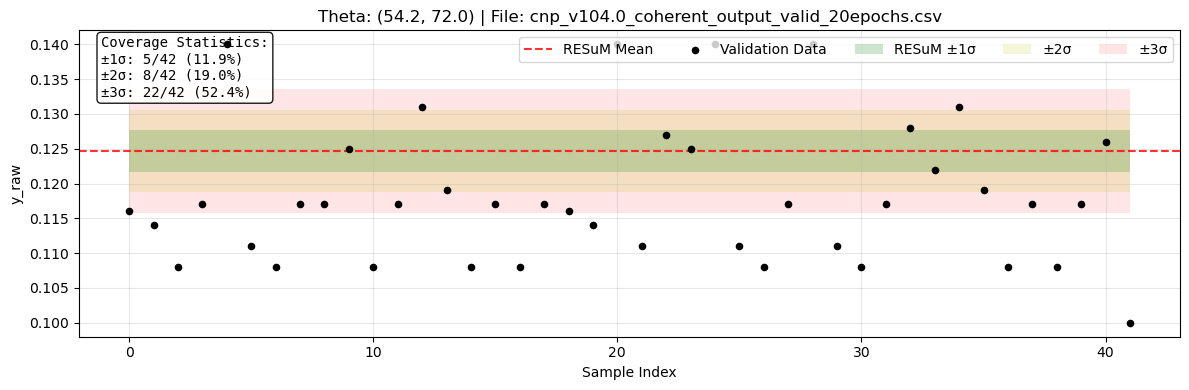

    Coverage statistics for Theta (54.2, 72.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 8/42 (19.0%)
    ±3σ: 22/42 (52.4%)
  Theta: (112.2, 14.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_112.2_14.0.png


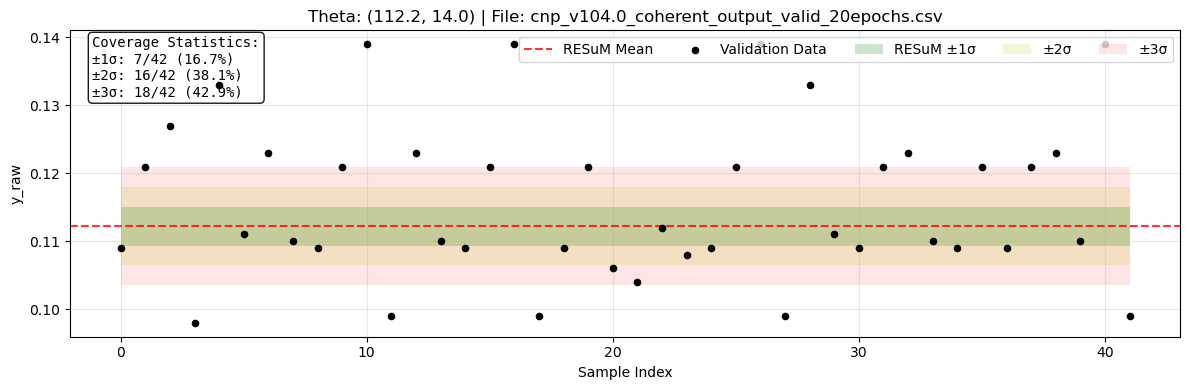

    Coverage statistics for Theta (112.2, 14.0):
    ±1σ: 7/42 (16.7%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 18/42 (42.9%)
  Theta: (17.2, 109.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_17.2_109.0.png


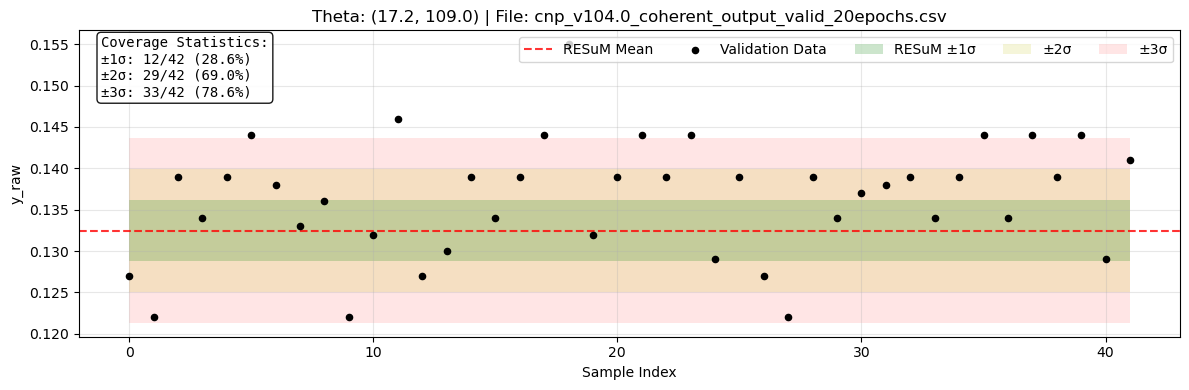

    Coverage statistics for Theta (17.2, 109.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 29/42 (69.0%)
    ±3σ: 33/42 (78.6%)
  Theta: (20.2, 106.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_20.2_106.0.png


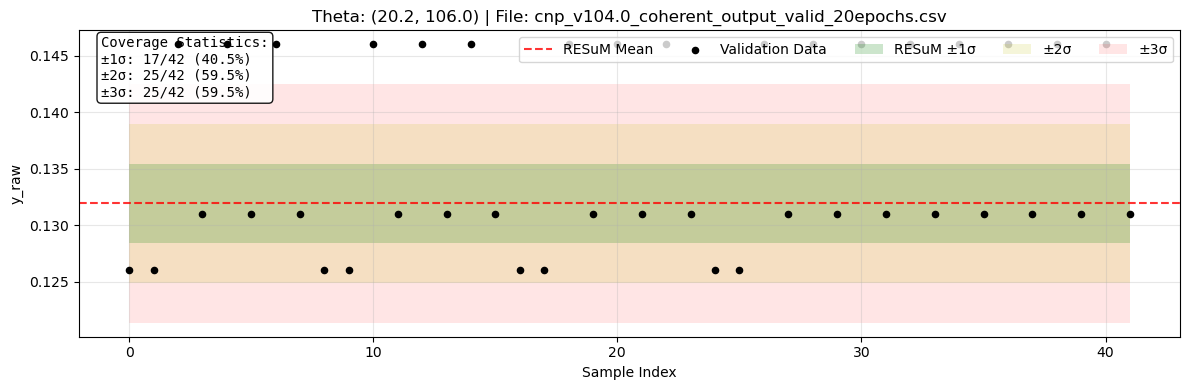

    Coverage statistics for Theta (20.2, 106.0):
    ±1σ: 17/42 (40.5%)
    ±2σ: 25/42 (59.5%)
    ±3σ: 25/42 (59.5%)
  Theta: (48.2, 78.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_48.2_78.0.png


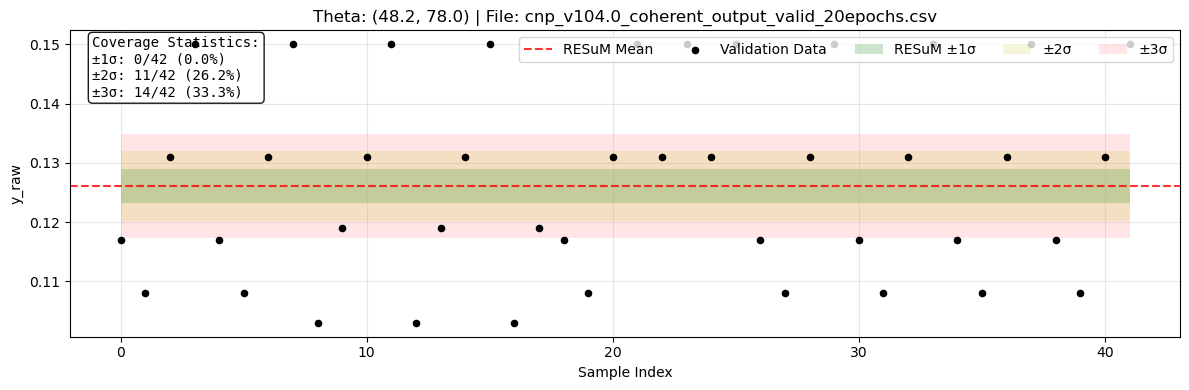

    Coverage statistics for Theta (48.2, 78.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 11/42 (26.2%)
    ±3σ: 14/42 (33.3%)
  Theta: (22.2, 104.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_22.2_104.0.png


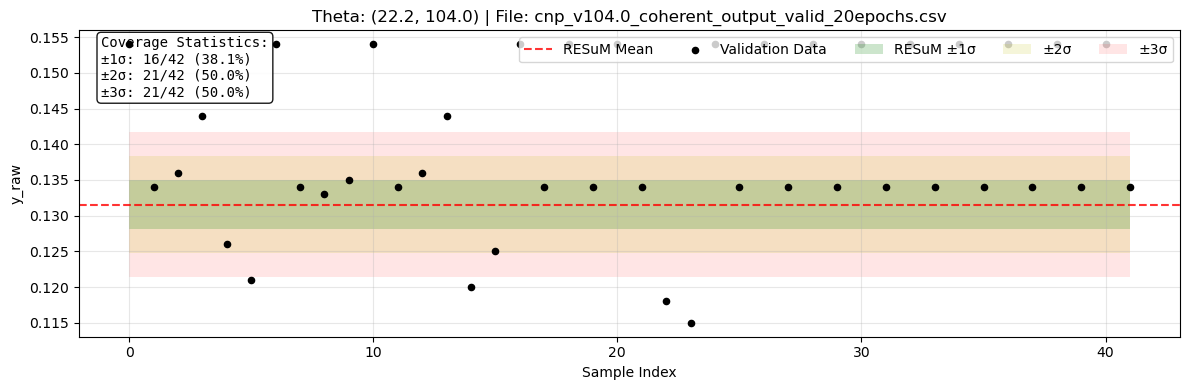

    Coverage statistics for Theta (22.2, 104.0):
    ±1σ: 16/42 (38.1%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (52.2, 74.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_52.2_74.0.png


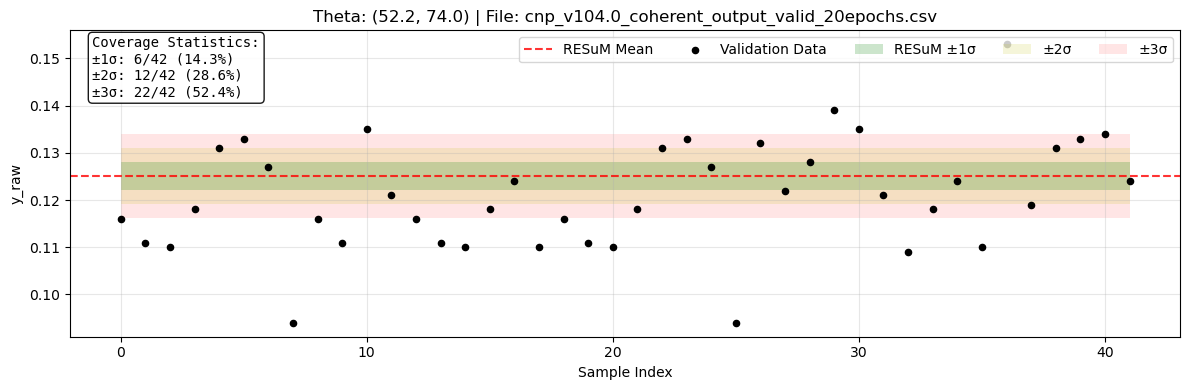

    Coverage statistics for Theta (52.2, 74.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 12/42 (28.6%)
    ±3σ: 22/42 (52.4%)
  Theta: (80.2, 46.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_80.2_46.0.png


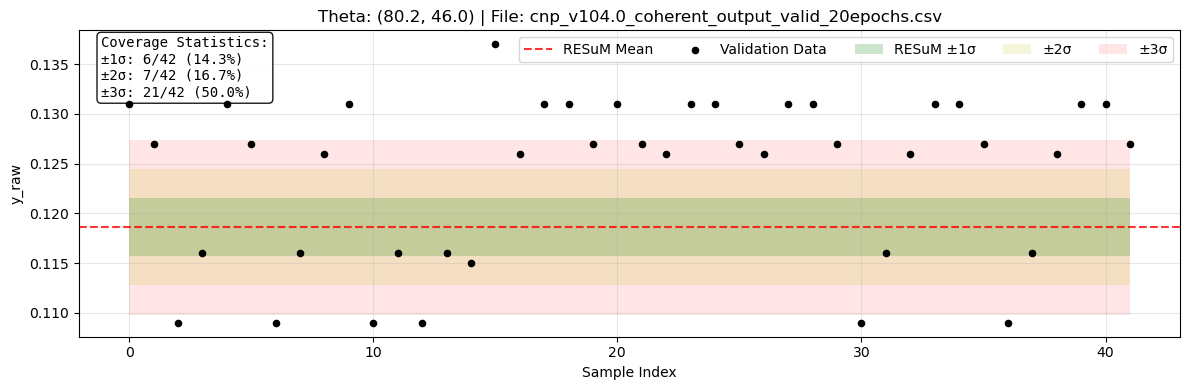

    Coverage statistics for Theta (80.2, 46.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 7/42 (16.7%)
    ±3σ: 21/42 (50.0%)
  Theta: (30.2, 96.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_30.2_96.0.png


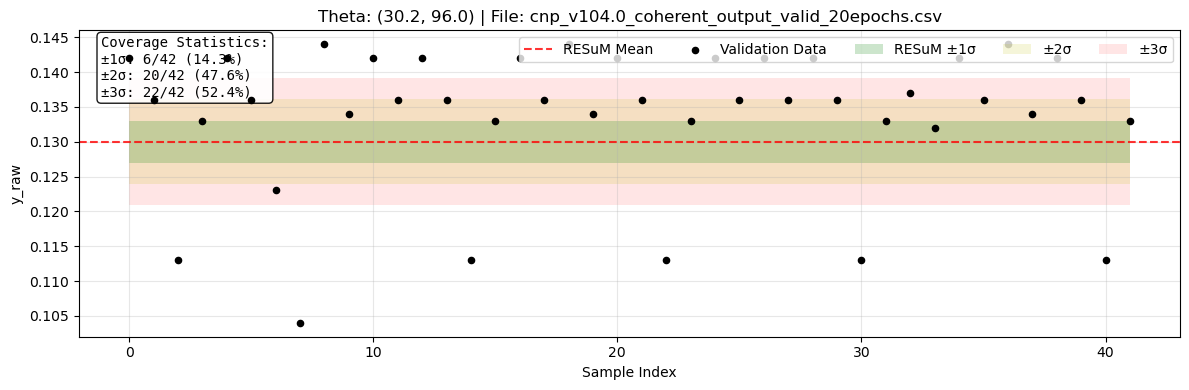

    Coverage statistics for Theta (30.2, 96.0):
    ±1σ: 6/42 (14.3%)
    ±2σ: 20/42 (47.6%)
    ±3σ: 22/42 (52.4%)
  Theta: (40.2, 86.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_40.2_86.0.png


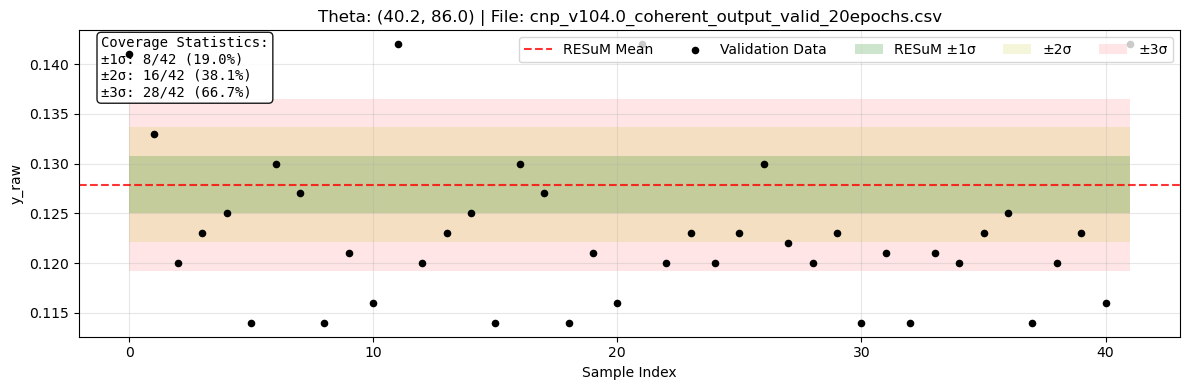

    Coverage statistics for Theta (40.2, 86.0):
    ±1σ: 8/42 (19.0%)
    ±2σ: 16/42 (38.1%)
    ±3σ: 28/42 (66.7%)
  Theta: (77.2, 49.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_77.2_49.0.png


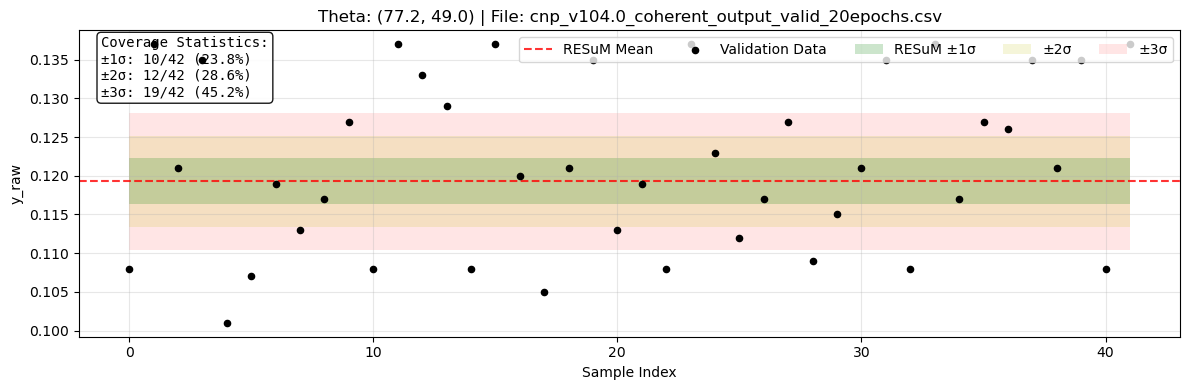

    Coverage statistics for Theta (77.2, 49.0):
    ±1σ: 10/42 (23.8%)
    ±2σ: 12/42 (28.6%)
    ±3σ: 19/42 (45.2%)
  Theta: (78.2, 48.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_78.2_48.0.png


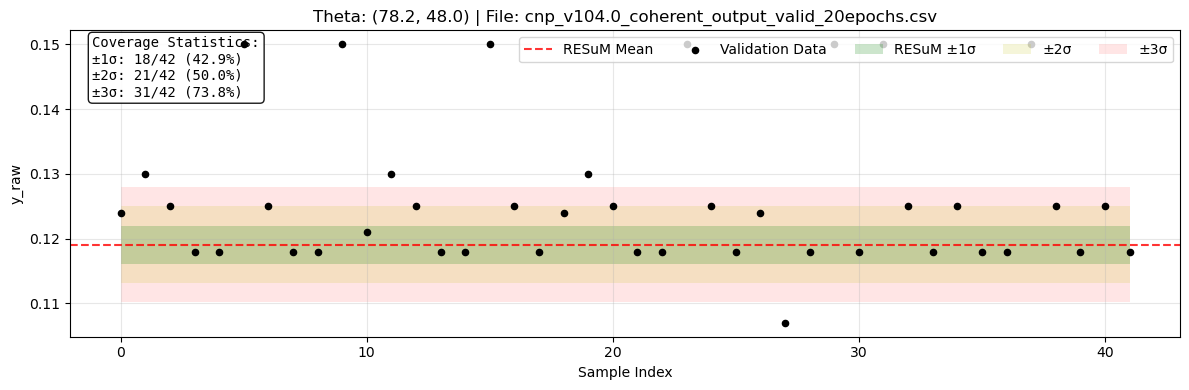

    Coverage statistics for Theta (78.2, 48.0):
    ±1σ: 18/42 (42.9%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 31/42 (73.8%)
  Theta: (27.2, 99.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_27.2_99.0.png


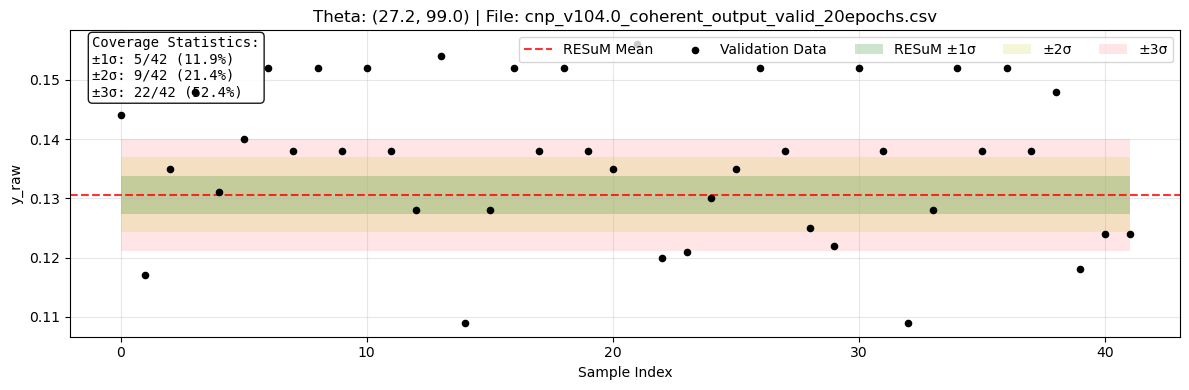

    Coverage statistics for Theta (27.2, 99.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 9/42 (21.4%)
    ±3σ: 22/42 (52.4%)
  Theta: (19.2, 107.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_19.2_107.0.png


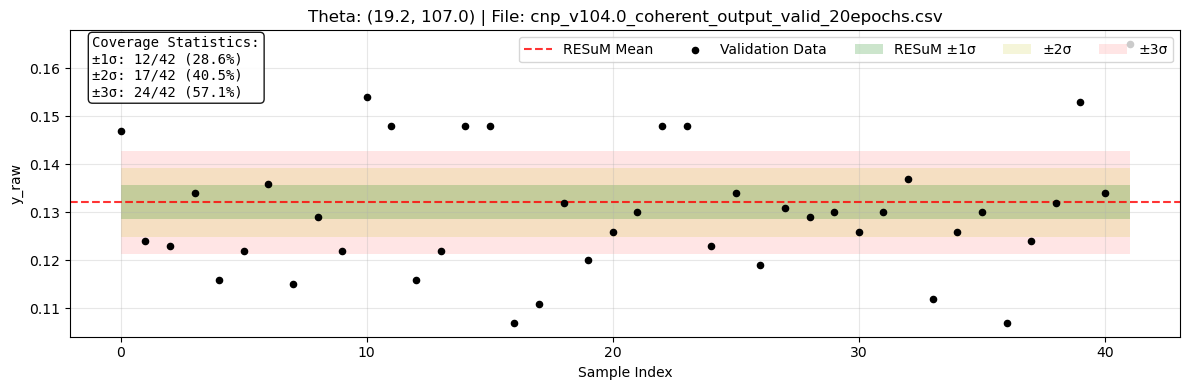

    Coverage statistics for Theta (19.2, 107.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 17/42 (40.5%)
    ±3σ: 24/42 (57.1%)
  Theta: (103.2, 23.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_103.2_23.0.png


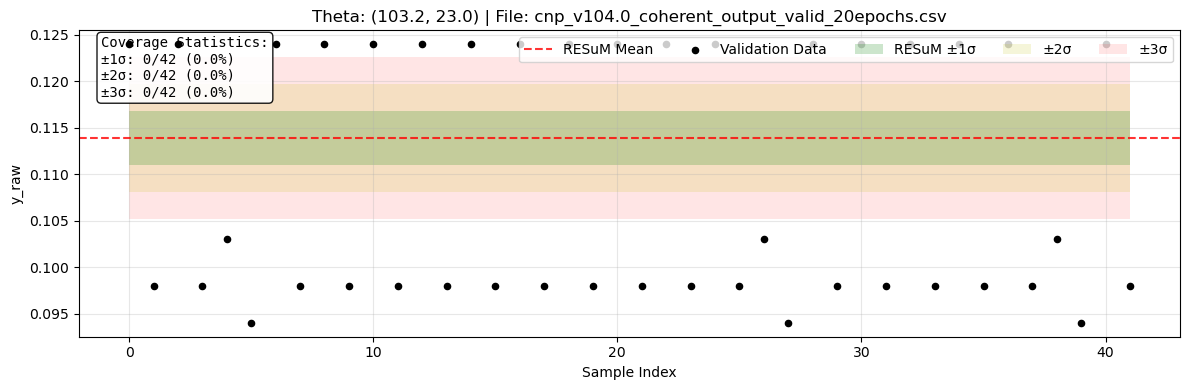

    Coverage statistics for Theta (103.2, 23.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 0/42 (0.0%)
    ±3σ: 0/42 (0.0%)
  Theta: (51.2, 75.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_51.2_75.0.png


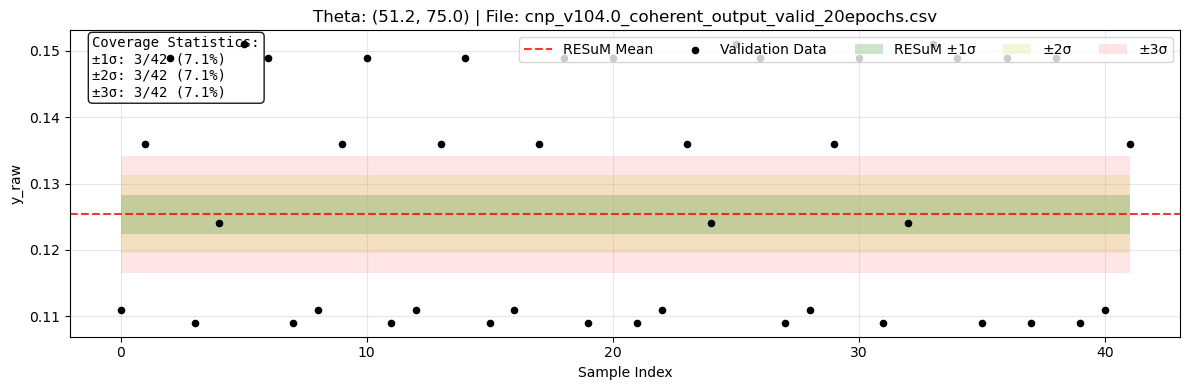

    Coverage statistics for Theta (51.2, 75.0):
    ±1σ: 3/42 (7.1%)
    ±2σ: 3/42 (7.1%)
    ±3σ: 3/42 (7.1%)
  Theta: (29.2, 97.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_29.2_97.0.png


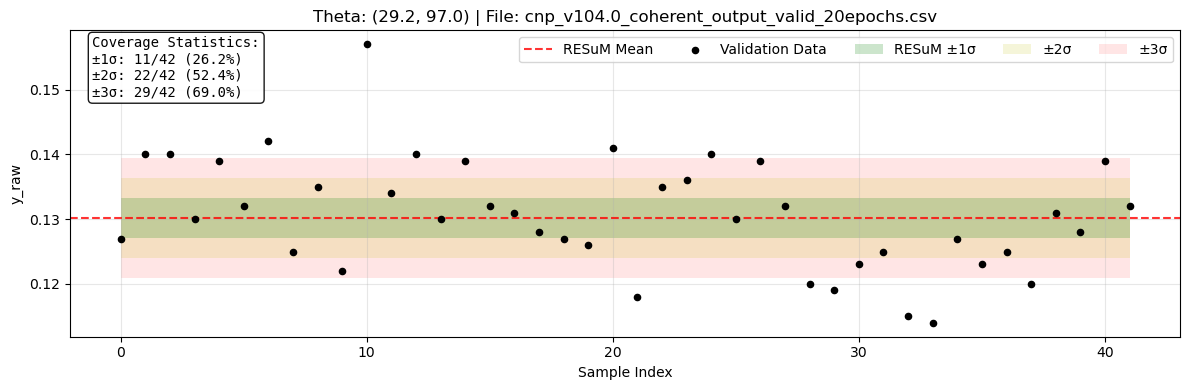

    Coverage statistics for Theta (29.2, 97.0):
    ±1σ: 11/42 (26.2%)
    ±2σ: 22/42 (52.4%)
    ±3σ: 29/42 (69.0%)
  Theta: (95.2, 31.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_95.2_31.0.png


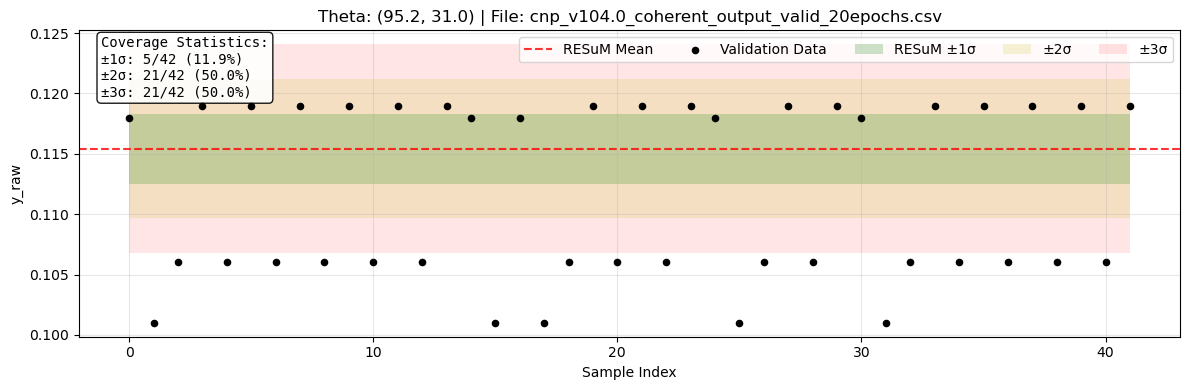

    Coverage statistics for Theta (95.2, 31.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (35.2, 91.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_35.2_91.0.png


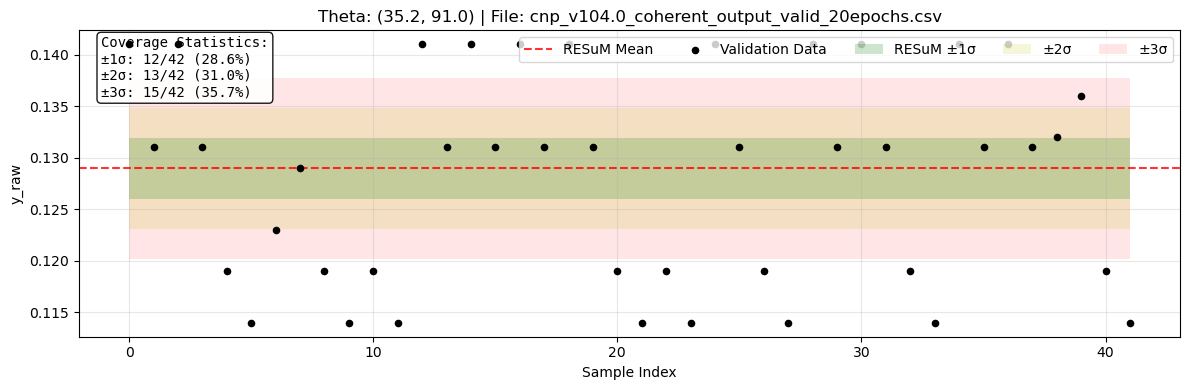

    Coverage statistics for Theta (35.2, 91.0):
    ±1σ: 12/42 (28.6%)
    ±2σ: 13/42 (31.0%)
    ±3σ: 15/42 (35.7%)
  Theta: (93.2, 33.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_93.2_33.0.png


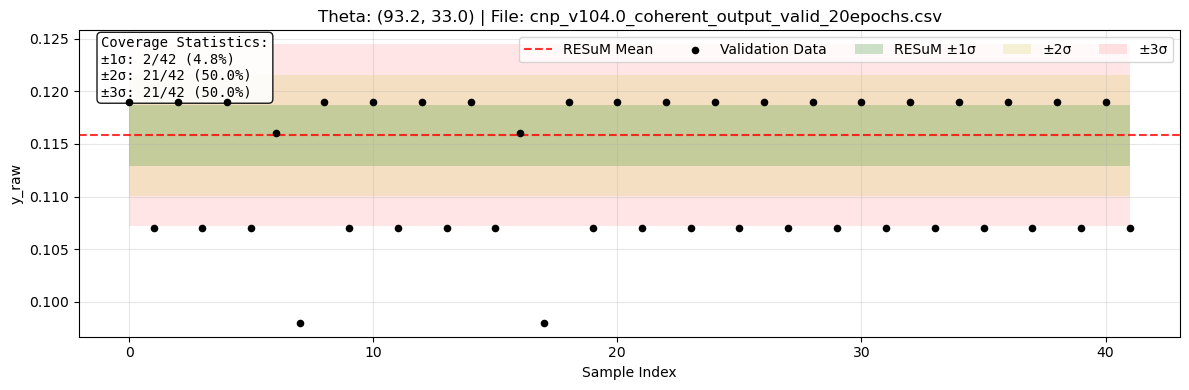

    Coverage statistics for Theta (93.2, 33.0):
    ±1σ: 2/42 (4.8%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 21/42 (50.0%)
  Theta: (88.2, 38.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_88.2_38.0.png


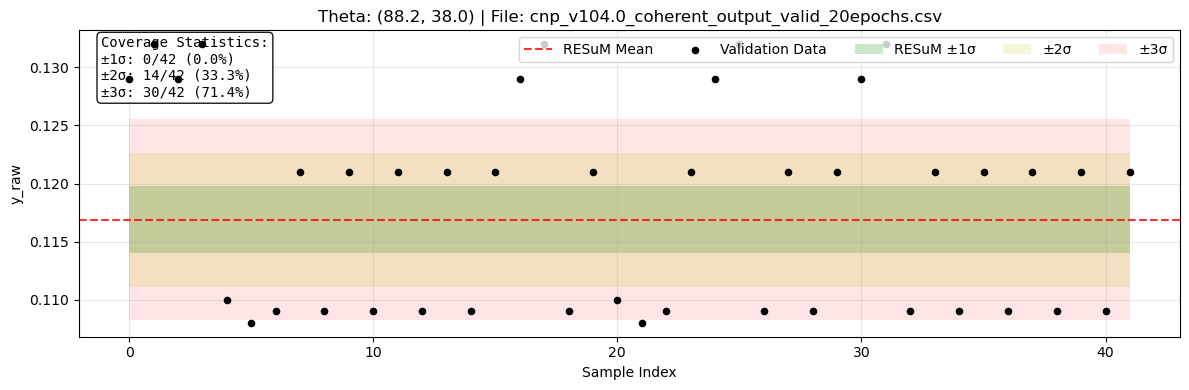

    Coverage statistics for Theta (88.2, 38.0):
    ±1σ: 0/42 (0.0%)
    ±2σ: 14/42 (33.3%)
    ±3σ: 30/42 (71.4%)
  Theta: (114.2, 12.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_114.2_12.0.png


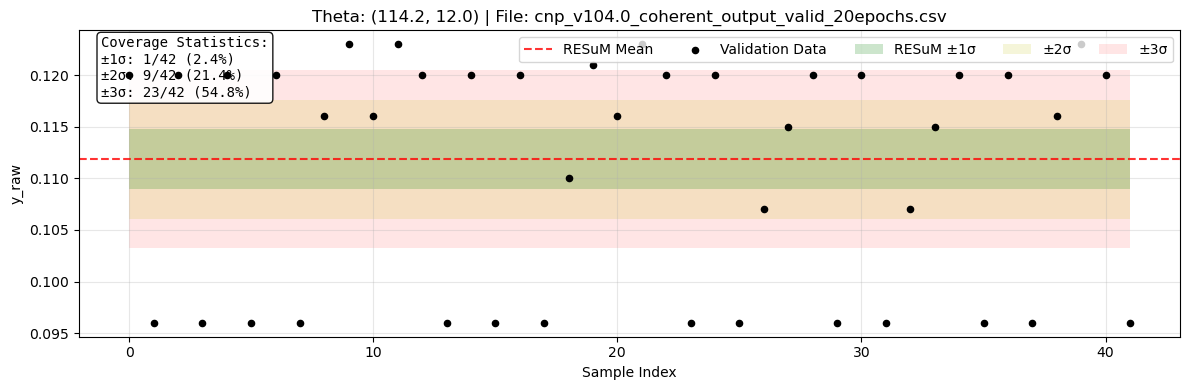

    Coverage statistics for Theta (114.2, 12.0):
    ±1σ: 1/42 (2.4%)
    ±2σ: 9/42 (21.4%)
    ±3σ: 23/42 (54.8%)
  Theta: (74.2, 52.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_74.2_52.0.png


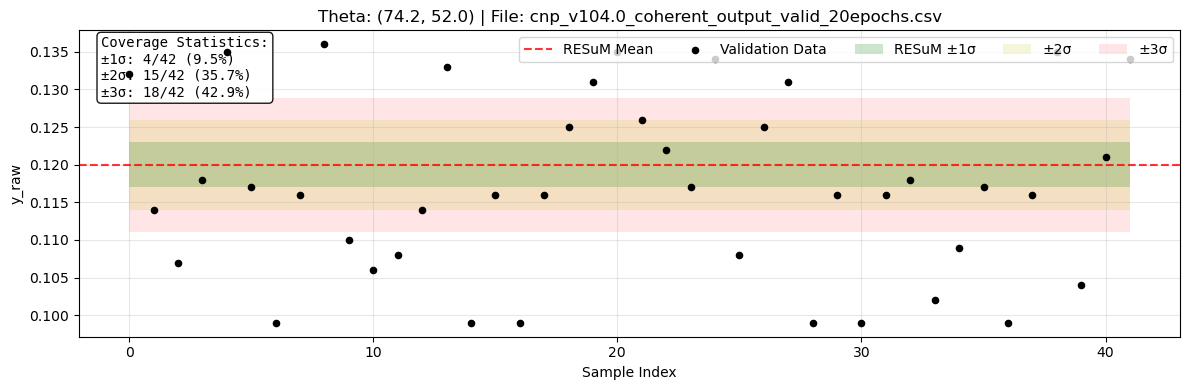

    Coverage statistics for Theta (74.2, 52.0):
    ±1σ: 4/42 (9.5%)
    ±2σ: 15/42 (35.7%)
    ±3σ: 18/42 (42.9%)
  Theta: (70.2, 56.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_70.2_56.0.png


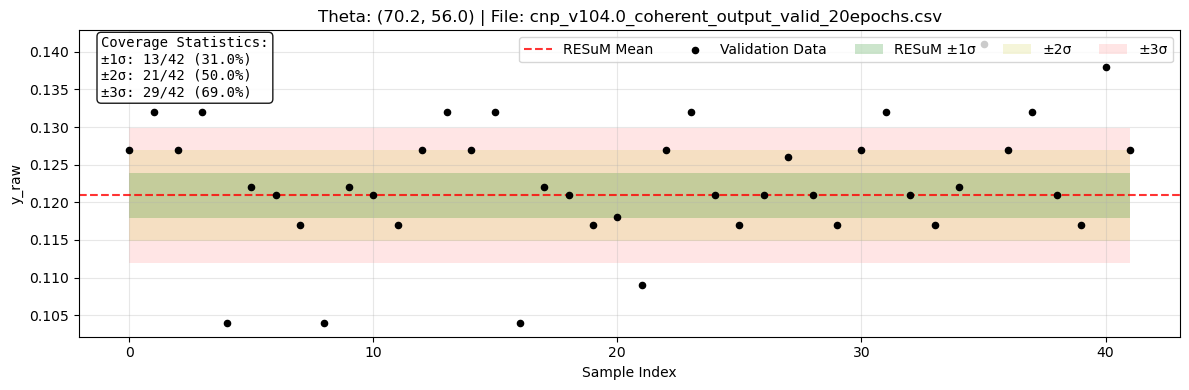

    Coverage statistics for Theta (70.2, 56.0):
    ±1σ: 13/42 (31.0%)
    ±2σ: 21/42 (50.0%)
    ±3σ: 29/42 (69.0%)
  Theta: (104.2, 22.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_104.2_22.0.png


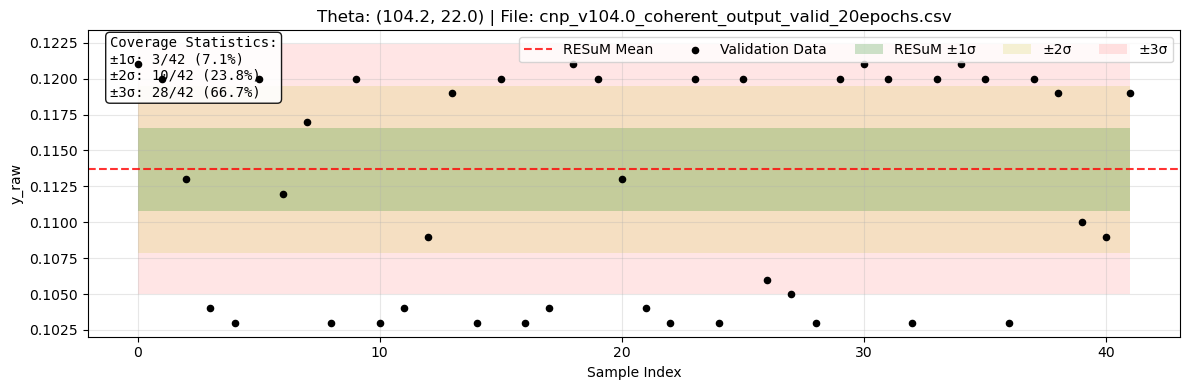

    Coverage statistics for Theta (104.2, 22.0):
    ±1σ: 3/42 (7.1%)
    ±2σ: 10/42 (23.8%)
    ±3σ: 28/42 (66.7%)
  Theta: (92.2, 34.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_92.2_34.0.png


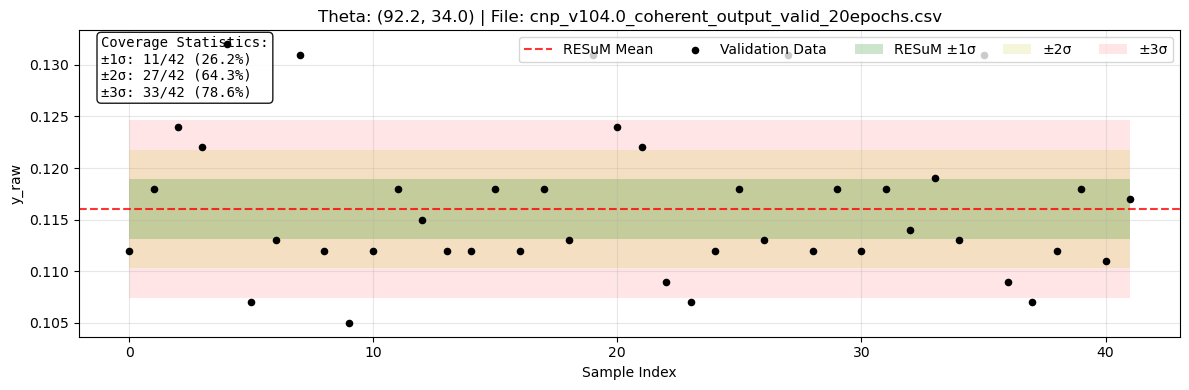

    Coverage statistics for Theta (92.2, 34.0):
    ±1σ: 11/42 (26.2%)
    ±2σ: 27/42 (64.3%)
    ±3σ: 33/42 (78.6%)
  Theta: (23.2, 103.0)
    Saved: ../coherent/out/mfgp/newdata/uncertainty_bands_cnp_v104.0_coherent_output_valid_20epochs_theta_23.2_103.0.png


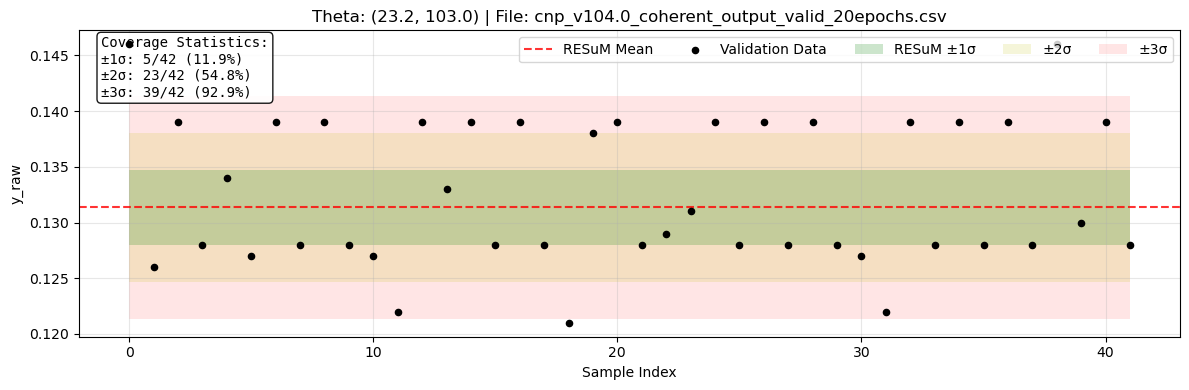

    Coverage statistics for Theta (23.2, 103.0):
    ±1σ: 5/42 (11.9%)
    ±2σ: 23/42 (54.8%)
    ±3σ: 39/42 (92.9%)

5. Creating coverage summary plots...
Coverage summary saved: ../coherent/out/mfgp/newdata/coverage_summary.png


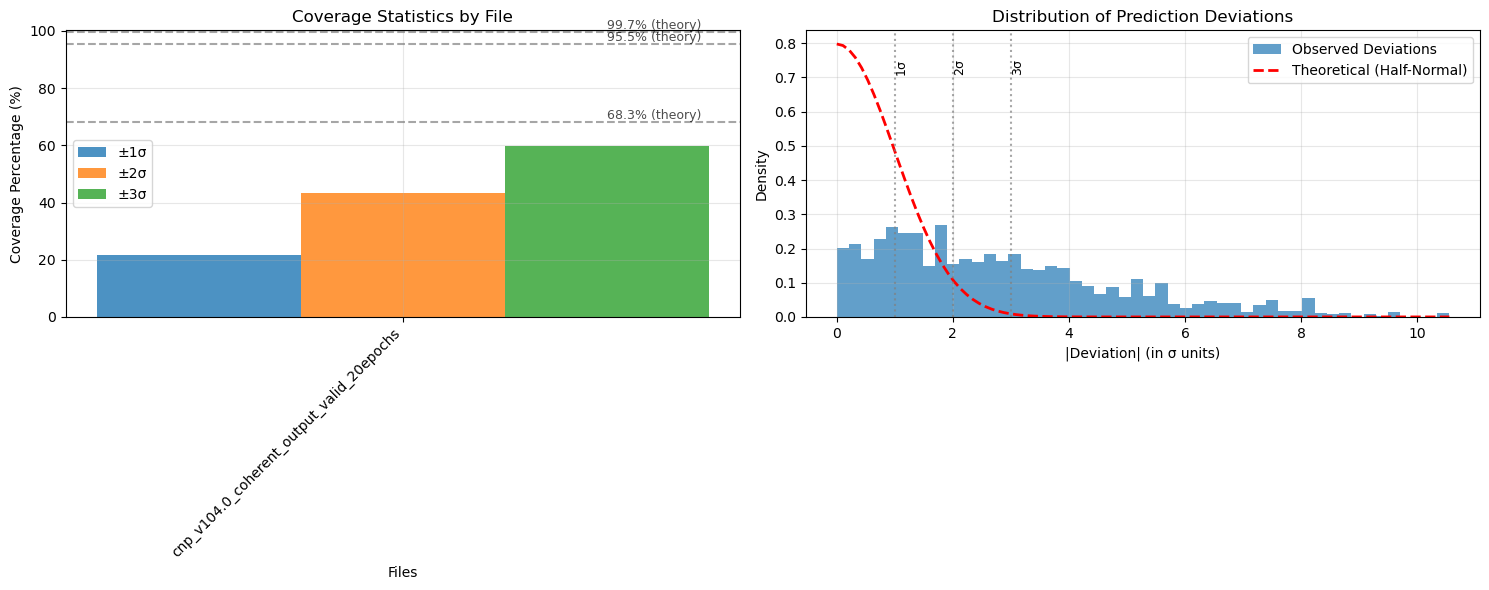


Overall Statistics (1 files, 3696 total points):
±1σ: 798/3696 (21.6%) | Theoretical: 68.3% | Diff: -46.7%
±2σ: 1598/3696 (43.2%) | Theoretical: 95.5% | Diff: -52.2%
±3σ: 2204/3696 (59.6%) | Theoretical: 99.7% | Diff: -40.1%

6. Creating enhanced contour analysis...
Enhanced contour analysis saved: ../coherent/out/mfgp/newdata/enhanced_contour_analysis.png


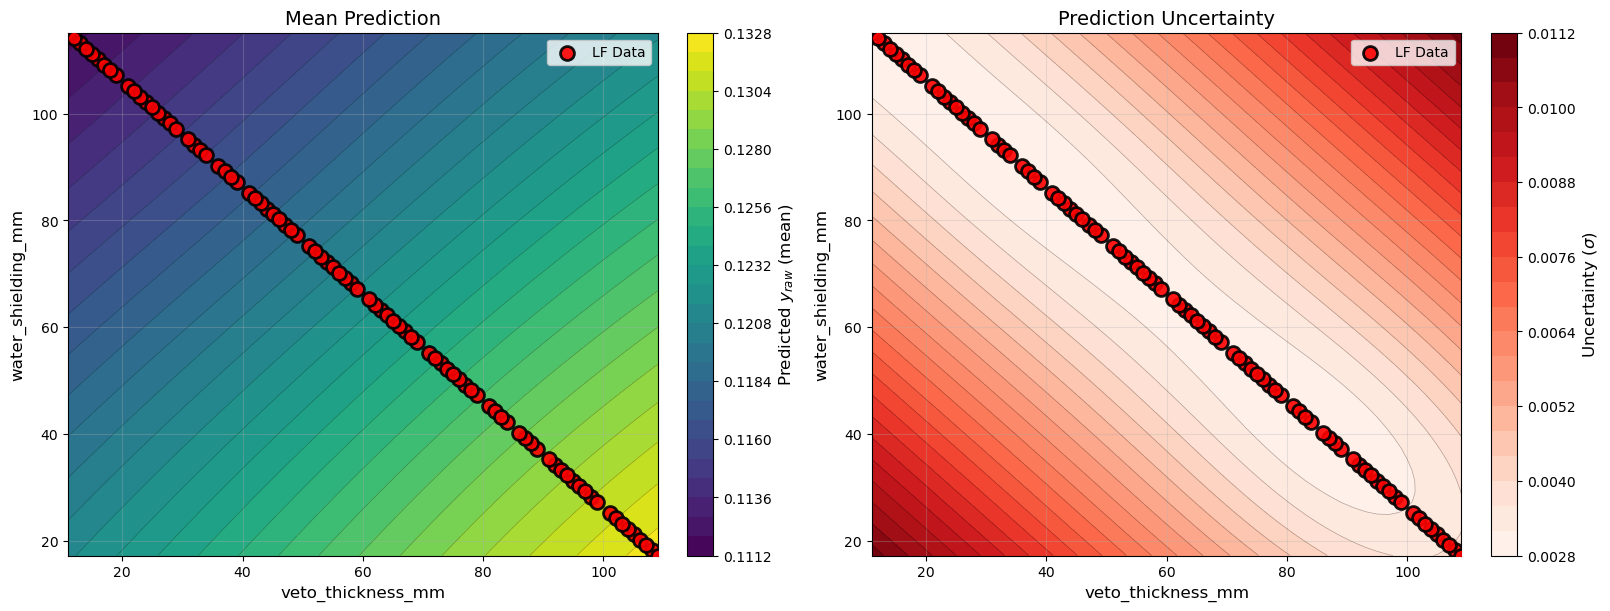


7. Creating prediction vs true value plots...
Prediction vs true (aggregated) plot saved: ../coherent/out/mfgp/newdata/predicted_vs_true_cnp_v104.0_coherent_output_valid_20epochs.png


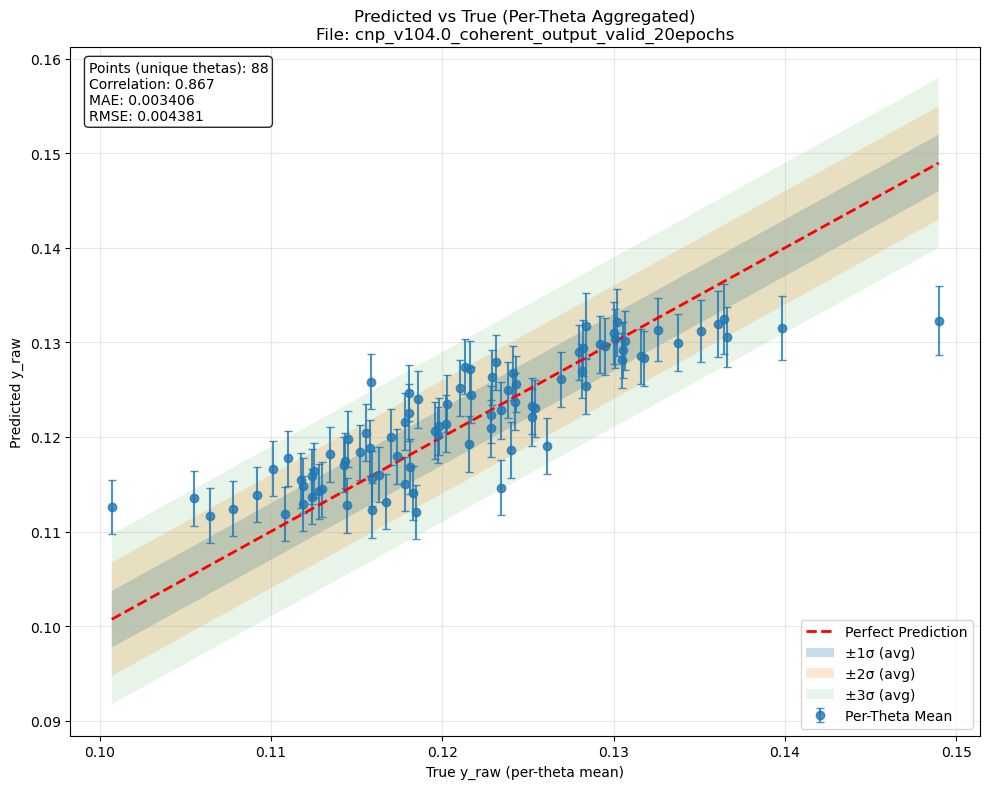


8. Creating plot across all theta values...
    Saved plot: ../coherent/out/mfgp/newdata/uncertainty_bands_across_thetas_cnp_v104.0_coherent_output_valid_20epochs.png


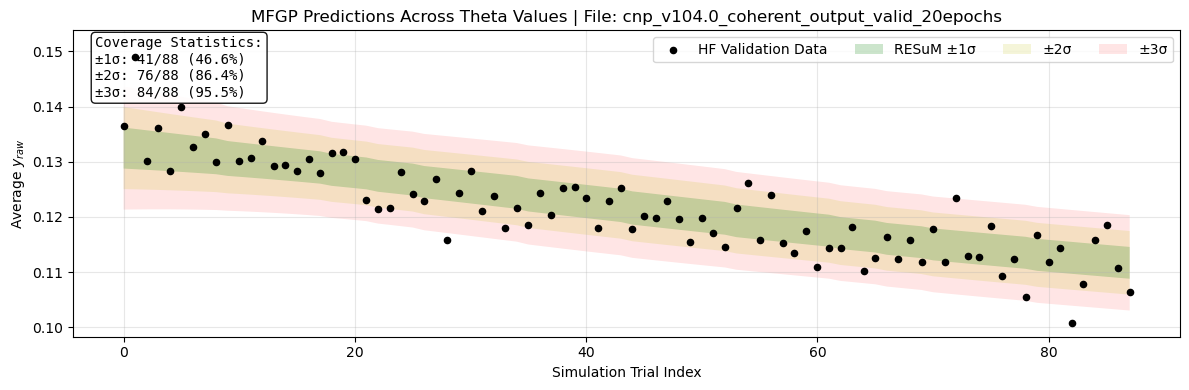


ANALYSIS COMPLETE!
All plots saved to: ../coherent/out/mfgp/newdata
🎉 Analysis complete! Check your output folder for all saved plots and results.


In [14]:
# Example 1: Analyze the current file that was used for training
print("="*60)
print("EXAMPLE 1: Analyzing the current training file")
print("="*60)

current_file_results = analyzer.run_complete_analysis(
    file_patterns=["/home/bliu4/resum-coherent2/examples/coherent/out/cnp/newdata/cnp_v104.0_coherent_output_valid_20epochs.csv"],  # The file we used for training
    fidelity_filter=0.0,     # High fidelity data
    iteration_filter=0,      # First iteration
    plot_individual_groups=True,  # Plot each theta combination
    save_all_plots=True      # 💾 Save ALL generated plots to output folder
)

print("🎉 Analysis complete! Check your output folder for all saved plots and results.")

## Summary of Automated Features ✅

The enhanced notebook now uses the **`MFGPAnalyzer`** class from `mfgp_analyzer.py` to provide comprehensive automated analysis:

### 🎯 **Key Features**
- ✅ **Multi-File Processing**: Supports glob patterns and file lists
- ✅ **Automated Predictions**: Batch processing for all theta combinations  
- ✅ **Uncertainty Visualization**: ±1σ, ±2σ, ±3σ confidence intervals
- ✅ **Coverage Statistics**: Comparison with theoretical normal distribution
- ✅ **Enhanced Contour Maps**: 4-panel analysis with data overlay
- ✅ **Comprehensive Analysis**: Prediction quality and error metrics
- ✅ **💾 Automatic Saving**: All plots saved to configured output folder**

### 📁 **File Output Structure**
When you run the analysis, the following files are automatically saved to your output folder:

```
{path_out_mfgp}/
├── uncertainty_bands_{file}_{theta}.png      # Individual theta plots
├── coverage_summary.png                      # Coverage statistics  
├── enhanced_contour_analysis.png             # 4-panel contour analysis
├── predicted_vs_true_{file}.png              # Prediction accuracy
├── yraw_contour_map.png                      # Original contour plots
└── yraw_contour_with_uncertainty.png         # Original uncertainty plots
```

### 🚀 **Quick Usage**

```python
# Import and initialize
from mfgp_analyzer import MFGPAnalyzer
analyzer = MFGPAnalyzer(model, x_labels, output_dir=path_out_mfgp)

# One-click full analysis
results = analyzer.run_complete_analysis(
    file_patterns=['data/*.csv'],  # Supports glob patterns
    save_all_plots=True           # 💾 Saves everything automatically
)
```

### 🔧 **Manual Control**

```python
# Step-by-step for custom analysis
processed_data = analyzer.load_and_process_csv_files(['file1.csv'])
predictions = analyzer.predict_for_theta_groups(processed_data)
coverage_stats = analyzer.calculate_coverage_statistics(predictions)

# Individual plotting (all save automatically)
analyzer.plot_coverage_summary(coverage_stats)
analyzer.create_enhanced_contour_plots(processed_data)
```

### 🎊 **Benefits**
1. **Clean Notebook**: Large class moved to separate file
2. **Automatic Saving**: All results saved to output folder  
3. **Scalable**: Handles any number of CSV files
4. **Comprehensive**: All requested visualizations included
5. **Flexible**: Both automated and manual workflows
6. **Robust**: Error handling and progress reporting